## Loading Libraries

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd  # import pandas library and give it an alias of pd
from scipy.stats import norm, kurtosis
import seaborn as sns
import math
import plotly.express as px
from matplotlib.ticker import PercentFormatter
from datetime import timedelta, date
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
from xgboost import XGBClassifier
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from pandas import read_csv
from sklearn.feature_selection import RFE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot

C:\Users\92306\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
!pip install scikit-plot

## Loading Data

In [2]:
sales1 = pd.read_excel (r'/Users/92306/OneDrive/Documents/sales1.xlsx')
sales2 = pd.read_excel (r'/Users/92306/OneDrive/Documents/sales2.xlsx')
account = pd.read_excel (r'/Users/92306/OneDrive/Documents/account.xlsx')
contact1 = pd.read_excel (r'/Users/92306/OneDrive/Documents/contact_features.xlsx')
contact = pd.read_excel (r'/Users/92306/OneDrive/Documents/contact.xlsx')
family = pd.read_excel (r'/Users/92306/OneDrive/Documents/family.xlsx')
top_sellers = pd.read_excel (r'/Users/92306/OneDrive/Documents/top_selling_items.xlsx')


## Preparing Consolidated Sales Data

Importing Sales Data 

In [3]:
# Merging Sales Data
sales = pd.concat([sales1,sales2])
# Working towards new primary key Customer_time. This will be treated as a single observation
sales["customer_time"] = sales["Customer No"].astype(str) + sales["Posting Date"].astype(str)
# Filtering customers having customer no empty or blank
sales = sales[sales['Customer No'].apply(len) == 7]

Consolidating the data transaction wise (Based on customer_time)

In [4]:
sales_consolidated = sales.groupby(['customer_time'])['Quantity Ordered','Line Item Amount'].sum().reset_index()
sales_consolidated1 = sales.groupby(['customer_time'])['Quantity Ordered','Line Item Amount'].sum().reset_index()
sales_consolidated1['Customer No'] = sales_consolidated1['customer_time'].str[:7]
sales_consolidated1['Posting Date'] = sales_consolidated1['customer_time'].str[7:]
sales_consolidated['Customer No'] = sales_consolidated['customer_time'].str[:7]
sales_consolidated['Posting Date'] = sales_consolidated['customer_time'].str[7:]

# Bringing next order/transaction date against the existing transaction

sales_consolidated.loc[sales_consolidated['Customer No'] == sales_consolidated['Customer No'].shift(-1),'next_order_date'] = sales_consolidated['Posting Date'].shift(-1) 
sales_consolidated.loc[sales_consolidated['next_order_date'].isnull(),'next_order_date'] = pd.to_datetime('today')
sales_consolidated['next_order_date'] = pd.to_datetime(sales_consolidated['next_order_date'])
sales_consolidated['Posting Date']=pd.to_datetime(sales_consolidated['Posting Date'])

#Computing time to order in days

sales_consolidated['time_to_order'] = sales_consolidated['next_order_date'] - sales_consolidated['Posting Date']
sales_consolidated['time_to_order'] = sales_consolidated['time_to_order']/np.timedelta64(1,'D')

#Forcing the minimum order time to be 30 days

sales_consolidated.loc[sales_consolidated['time_to_order'] < 30,'time_to_order'] = 30

# Assigning each customer an ID and counting the number of transactions for each customer 
sales_consolidated['block'] = (sales_consolidated['Customer No'] != sales_consolidated['Customer No'].shift(1)).astype(int).cumsum()
sales_consolidated['count'] = sales_consolidated.groupby((sales_consolidated['Customer No'] != sales_consolidated['Customer No'].shift(1)).cumsum()).cumcount()+1

<ipython-input-4-9d142cd58430>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_consolidated = sales.groupby(['customer_time'])['Quantity Ordered','Line Item Amount'].sum().reset_index()
<ipython-input-4-9d142cd58430>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_consolidated1 = sales.groupby(['customer_time'])['Quantity Ordered','Line Item Amount'].sum().reset_index()


### Churn Standard

Computing expected purchase window for each customer

In [5]:
sales_consolidated['cumulative_sum_time'] = sales_consolidated.groupby('Customer No')['time_to_order'].cumsum()
sales_consolidated.loc[sales_consolidated['Customer No'] == sales_consolidated['Customer No'].shift(1),'cumulative_sum_time_shifted'] = sales_consolidated['cumulative_sum_time'].shift(1) 
sales_consolidated.loc[sales_consolidated['Customer No'] == sales_consolidated['Customer No'].shift(1),'count_shifted'] = sales_consolidated['count'].shift(1) 
sales_consolidated.loc[sales_consolidated['count'] > 1, 'expected_purchase_window'] = sales_consolidated['cumulative_sum_time_shifted']/sales_consolidated['count_shifted']
sales_consolidated.drop(['cumulative_sum_time', 'cumulative_sum_time_shifted','count_shifted'], axis=1, inplace=True)

Checking the distribution of expected purchase time between the first and second sale for all customers. 

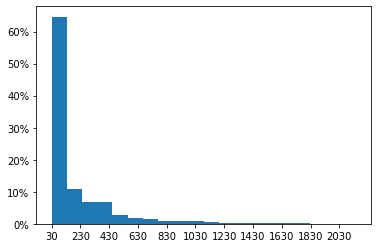

In [6]:
s = sales_consolidated.loc[sales_consolidated['count'] == 2]['expected_purchase_window']
plt.hist(s, weights=np.ones(len(s)) / len(s), bins = 20)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(np.arange(min(s), max(s), 200))
plt.show()

60-70% of customers take less than 100 days between their 1st and 2nd sale

In [7]:
# Setting expected purchase window = 60 for the first transaction based on the graph above
sales_consolidated.loc[sales_consolidated['count'] == 1, 'expected_purchase_window'] = 60

# Computing time to churn standard based on static multiplier of 4
sales_consolidated['time_to_churn_standard'] = sales_consolidated['expected_purchase_window']*4

In [8]:
sales_consolidated.loc[sales_consolidated['time_to_order'] < sales_consolidated['time_to_churn_standard'], 'churn_standard'] = 0
sales_consolidated.loc[sales_consolidated['time_to_order'] >= sales_consolidated['time_to_churn_standard'], 'churn_standard'] = 1

Marking last transaction for all the customer and removing single transaction customers

In [9]:
m1 = ~sales_consolidated.duplicated(['Customer No'], keep='last')
m2 = sales_consolidated.duplicated(['Customer No'], keep=False)
m = m1 & m2
sales_consolidated.loc[m, 'last'] = 'true'

sales_consolidated = sales_consolidated[sales_consolidated.duplicated('block',keep=False)]

In [10]:
sales_consolidated['Customer No'].nunique()/sales_consolidated1['Customer No'].nunique()

0.3914914677971208

We only have 39.1% such customers who have repeated entries or with repeated transactions. 60.9% customers only buy once from labelmaster.

### Churn Modified & Churn Score

Making column time to churn modified and churn modified based on modified multiplier

In [11]:
sales_consolidated.loc[(sales_consolidated['expected_purchase_window'] > 0) & (sales_consolidated['expected_purchase_window'] <= 60), 'time_to_churn_modified'] = sales_consolidated['time_to_churn_standard']
sales_consolidated.loc[(sales_consolidated['expected_purchase_window'] > 60) & (sales_consolidated['expected_purchase_window'] <= 120), 'time_to_churn_modified'] = sales_consolidated['expected_purchase_window']*3
sales_consolidated.loc[(sales_consolidated['expected_purchase_window'] > 120) & (sales_consolidated['expected_purchase_window'] <= 240), 'time_to_churn_modified'] = sales_consolidated['expected_purchase_window']*2
sales_consolidated.loc[(sales_consolidated['expected_purchase_window'] > 240), 'time_to_churn_modified'] = sales_consolidated['expected_purchase_window']

sales_consolidated.loc[sales_consolidated['time_to_order'] < sales_consolidated['time_to_churn_modified'], 'churn_modified'] = 0
sales_consolidated.loc[sales_consolidated['time_to_order'] >= sales_consolidated['time_to_churn_modified'], 'churn_modified'] = 1

In [12]:
## Making churn score column. This basically tells us about the state of the customer at a particular point in time
sales_consolidated['churn_score'] = sales_consolidated['time_to_order']/sales_consolidated['time_to_churn_standard']*100
sales_consolidated.loc[sales_consolidated['churn_score'] > 100,'churn_score'] = 100

sales_consolidated.loc[(sales_consolidated['churn_score'] < 25),'churn alarm'] = 'Normal'
sales_consolidated.loc[(sales_consolidated['churn_score'] >= 25) & (sales_consolidated['churn_score'] < 50),'churn alarm'] = 'slightly concerning'
sales_consolidated.loc[(sales_consolidated['churn_score'] >= 50) & (sales_consolidated['churn_score'] < 75),'churn alarm'] = 'very concerning'
sales_consolidated.loc[(sales_consolidated['churn_score'] >=75),'churn alarm'] = 'critical'

### Preliminary Churn Analysis

Checking year wise churn rate of repeated customers

In [13]:
sales_consolidated['year'] = pd.DatetimeIndex(sales_consolidated['Posting Date']).year
churned_year = sales_consolidated.loc[(sales_consolidated['churn_standard'] == 1) & (sales_consolidated['last'] == 'true') , ['Customer No','year']]
churned_year = churned_year.groupby('year').count()
customer_year = sales_consolidated.groupby('year')['Customer No'].nunique()
year_wise_churn = churned_year['Customer No']/customer_year*100

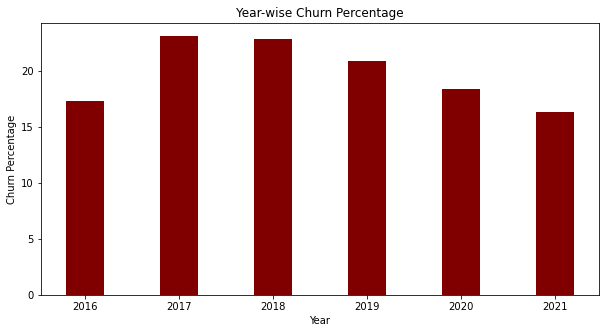

In [29]:
year_wise_churn = year_wise_churn.to_frame().reset_index()
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(year_wise_churn['year'], year_wise_churn['Customer No'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Year")
plt.ylabel("Churn Percentage")
plt.title("Year-wise Churn Percentage")
plt.show()

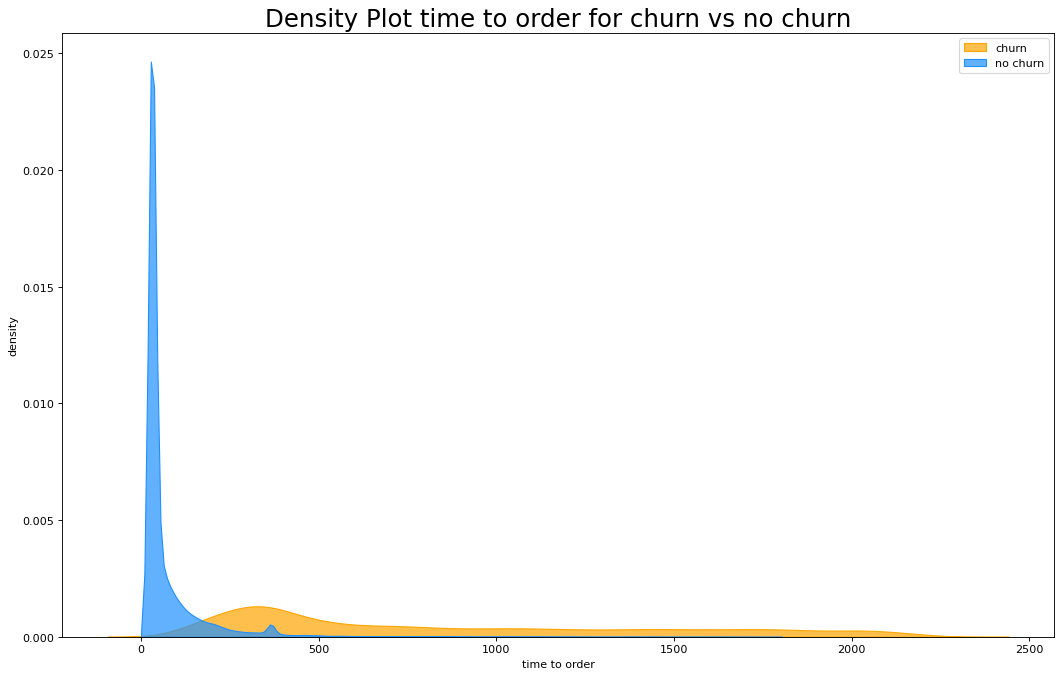

In [416]:
## Checking distribution of how much time it takes to make another order for churn and non-churn customers
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(sales_consolidated.loc[sales_consolidated['churn_standard'] == 1, "time_to_order"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(sales_consolidated.loc[sales_consolidated['churn_standard'] == 0, "time_to_order"], shade=True, color="dodgerblue", label="no churn", alpha=.7)

plt.title('Density Plot time to order for churn vs no churn', fontsize=22)
plt.ylabel('density')
plt.xlabel('time to order')
plt.legend()
plt.show()

## Account Data Merging with Sales

In [14]:
account = account.rename(columns={"AccountNumber": "Customer No"})

## Bringing accounts data information in consolidated data
sales_account = pd.merge(sales_consolidated,
                 account,
                 on='Customer No', 
                 how='left')
## Making customer wise table side by side
sales_consolidated_lasttransaction = sales_account.loc[sales_account['last'] == 'true']

### Churn Rate vs Tier 

In [66]:
tier_wise_churn = sales_consolidated_lasttransaction.groupby(['year','Tier__c'])['churn_standard'].sum().reset_index()
tier_wise_churn = tier_wise_churn.loc[(tier_wise_churn.Tier__c != 'GOV')
                                                &(tier_wise_churn.Tier__c != 'GOVCON')]

year_count = sales_account.groupby(['year','Tier__c'])['Customer No'].nunique().reset_index()
tier_wise_churn = pd.merge(tier_wise_churn,
                 year_count,
                 on=('year','Tier__c'), 
                 how='left')

tier_wise_churn['churn_rate'] = tier_wise_churn['churn_standard']/tier_wise_churn['Customer No']*100
tier_2020 = tier_wise_churn.loc[tier_wise_churn['year'] == 2020]
tier_2021 = tier_wise_churn.loc[tier_wise_churn['year'] == 2021]

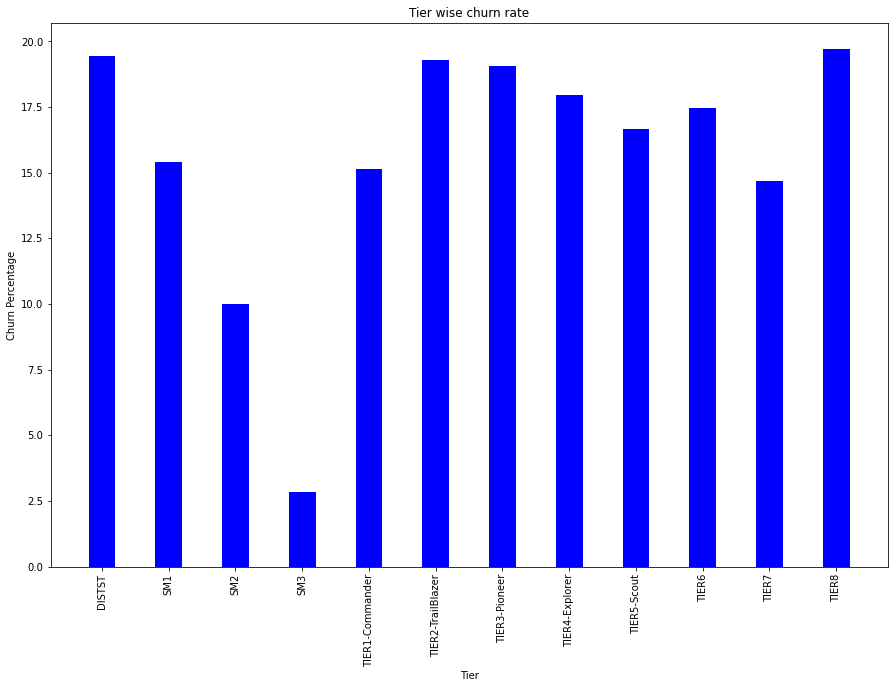

In [39]:
fig = plt.figure(figsize = (15, 10))
# creating the bar plot
plt.bar(tier_2020['Tier__c'], tier_2020['churn_rate'], color ='blue',
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Tier")
plt.ylabel("Churn Percentage")
plt.title("Tier wise churn rate")
plt.show()

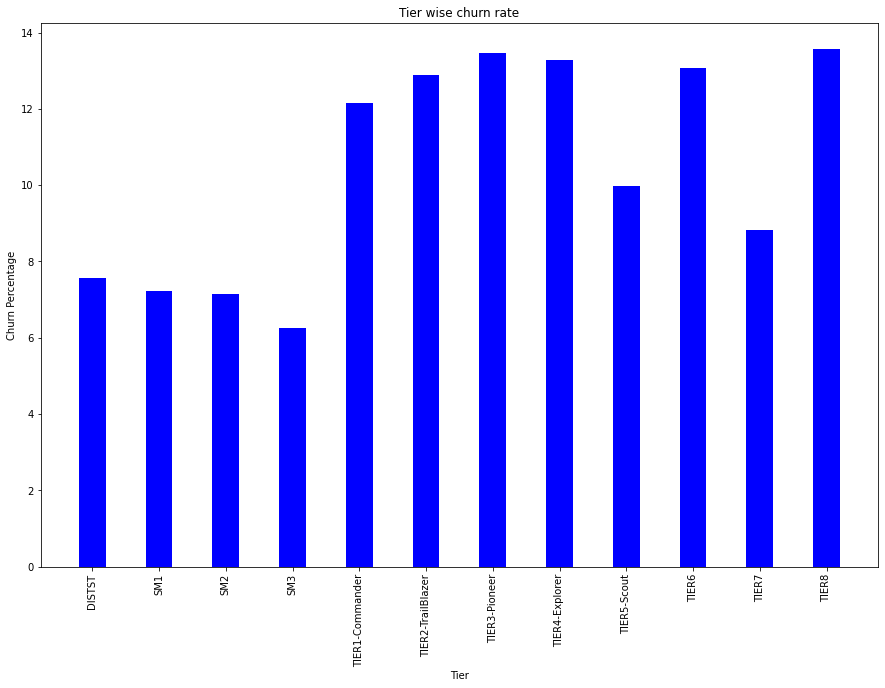

In [808]:
fig = plt.figure(figsize = (15, 10))
# creating the bar plot
plt.bar(tier_2021['Tier__c'], tier_2021['churn_rate'], color ='blue',
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Tier")
plt.ylabel("Churn Percentage")
plt.title("Tier wise churn rate")
plt.show()

The tier wise churn rate looks concerning and isn't what was expected. 

### Churn Rate vs Custom Client Revenue Ranges

In [15]:
### Merging Company Revenue Ranges for better view

sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == 'Under $500,000') | (sales_account['ZI_Company_Revenue_Range__c'] == '$500,000 - $1 mil.'), 'Client_revenue'] = 'Under $1mil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == '$1 mil. - $5 mil.') | (sales_account['ZI_Company_Revenue_Range__c'] == '$5 mil. - $10 mil.'), 'Client_revenue'] = '$1mil-$10mil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == '$10 mil. - $25 mil.') | (sales_account['ZI_Company_Revenue_Range__c'] == '$25 mil. - $50 mil.')| (sales_account['ZI_Company_Revenue_Range__c'] == '$50 mil. - $100 mil.'), 'Client_revenue'] = '$10mil-$100mil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == '$100 mil. - $250 mil.') | (sales_account['ZI_Company_Revenue_Range__c'] == '$250 mil. - $500 mil.'), 'Client_revenue'] = '$100mil-$500mil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == '$500,000 - $1 mil.') | (sales_account['ZI_Company_Revenue_Range__c'] == '$1 bil. - $5 bil.') , 'Client_revenue'] = '$500mil-$5bil'
sales_account.loc[(sales_account['ZI_Company_Revenue_Range__c'] == 'Over $5 bil.'), 'Client_revenue'] = 'Over $5bil'

sales_consolidated_lasttransaction = sales_account.loc[sales_account['last'] == 'true']
Client_revenue = sales_consolidated_lasttransaction.groupby(['Client_revenue','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','Client_revenue'])['Customer No'].nunique().reset_index()

Client_revenue = pd.merge(Client_revenue,
                 year_count,
                 on=('year','Client_revenue'), 
                 how='left')

Client_revenue['churn_rate'] = Client_revenue['churn_standard']/Client_revenue['Customer No']*100
Client_revenue_2020 = Client_revenue.loc[Client_revenue['year'] == 2020]
Client_revenue_2021 = Client_revenue.loc[Client_revenue['year'] == 2021]

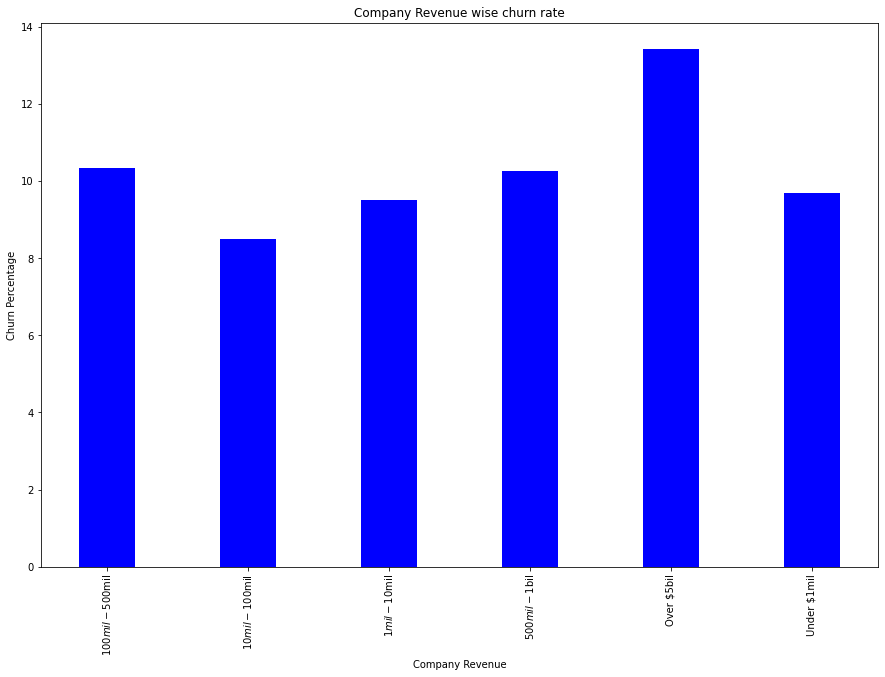

In [813]:
fig = plt.figure(figsize = (15, 10))
# creating the bar plot
plt.bar(Client_revenue_2021['Client_revenue'], Client_revenue_2021['churn_rate'], color ='blue',
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Company Revenue")
plt.ylabel("Churn Percentage")
plt.title("Company Revenue wise churn rate")
plt.show()

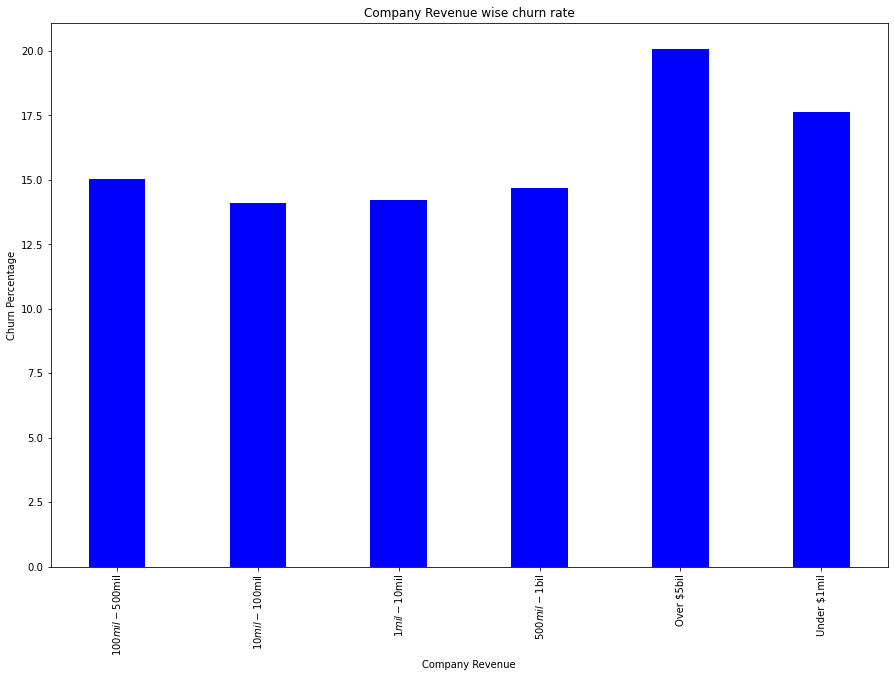

In [814]:
fig = plt.figure(figsize = (15, 10))
# creating the bar plot
plt.bar(Client_revenue_2020['Client_revenue'], Client_revenue_2020['churn_rate'], color ='blue',
        width = 0.4)
plt.xticks(rotation=90)
plt.xlabel("Company Revenue")
plt.ylabel("Churn Percentage")
plt.title("Company Revenue wise churn rate")
plt.show()

### Churn Rate vs Customer Lifetime Revenue Buckets

In [16]:
### Checking Churn Rate trend CLV wise and making CLV buckets
sales_account['cumulative_sum_revenue'] = sales_account.groupby('Customer No')['Line Item Amount'].cumsum()
sales_account.loc[(sales_account['cumulative_sum_revenue'] < 1000), 'revenue_bucket'] = 1
sales_account.loc[(sales_account['cumulative_sum_revenue'] >= 1000) & (sales_account['cumulative_sum_revenue'] < 2500), 'revenue_bucket'] = 2
sales_account.loc[(sales_account['cumulative_sum_revenue'] >= 2500) & (sales_account['cumulative_sum_revenue'] <= 5000), 'revenue_bucket'] = 3
sales_account.loc[(sales_account['cumulative_sum_revenue'] > 5000) & (sales_account['cumulative_sum_revenue'] <= 10000), 'revenue_bucket'] = 4                               
sales_account.loc[(sales_account['cumulative_sum_revenue'] > 10000), 'revenue_bucket'] = 5

sales_consolidated_lasttransaction = sales_account.loc[sales_account['last'] == 'true']
revenue_churn = sales_consolidated_lasttransaction.groupby(['revenue_bucket','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','revenue_bucket'])['Customer No'].nunique().reset_index()
revenue_churn = pd.merge(revenue_churn,
                 year_count,
                 on=('year','revenue_bucket'), 
                 how='left')
revenue_churn['churn_rate'] = revenue_churn['churn_standard']/revenue_churn['Customer No']*100
revenue_churn_2020 = revenue_churn.loc[revenue_churn['year'] == 2020]
revenue_churn_2021 = revenue_churn.loc[revenue_churn['year'] == 2021]

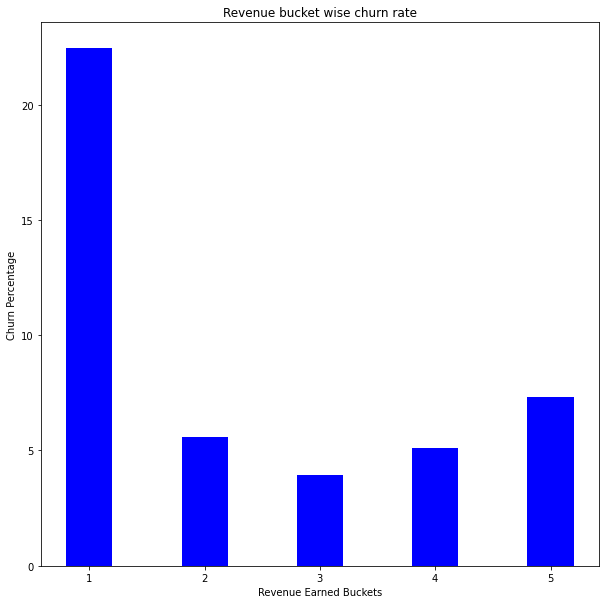

In [587]:
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
plt.bar(revenue_churn_2021['revenue_bucket'], revenue_churn_2021['churn_rate'], color ='blue',
        width = 0.4)
plt.xlabel("Revenue Earned Buckets")
plt.ylabel("Churn Percentage")
plt.title("Revenue bucket wise churn rate")
plt.show()

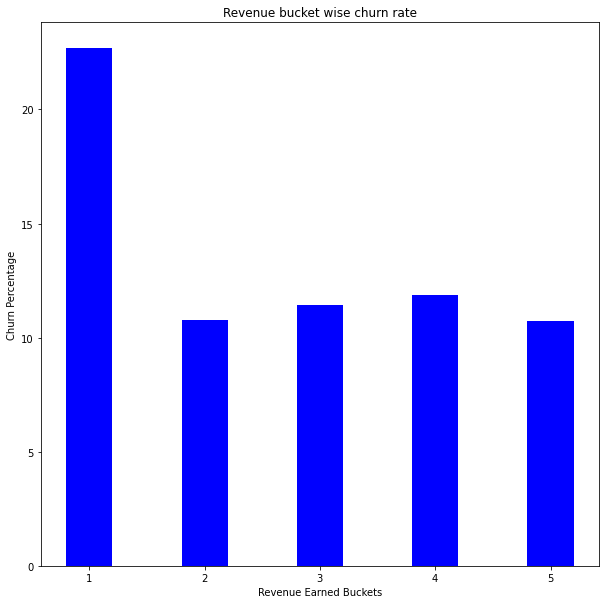

In [588]:
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
plt.bar(revenue_churn_2020['revenue_bucket'], revenue_churn_2020['churn_rate'], color ='blue',
        width = 0.4)
plt.xlabel("Revenue Earned Buckets")
plt.ylabel("Churn Percentage")
plt.title("Revenue bucket wise churn rate")
plt.show()

### Churn Rate vs Number of Transactions

In [17]:
###Checking Churn Rate as a function of number of transaction. 
labels_4 = ['first_quintile', 'second_quintile', 'third_quintile', 'fourth_quintile','fifth_quintile']
sales_account['count_group'] = pd.qcut(sales_account['count'],q=[0,0.2,0.4,0.6,0.8,1],labels=labels_4)

sales_consolidated_lasttransaction = sales_account.loc[sales_account['last'] == 'true']
count_churn = sales_consolidated_lasttransaction.groupby(['count_group','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','count_group'])['Customer No'].nunique().reset_index()

count_churn = pd.merge(count_churn,
                 year_count,
                 on=('year','count_group'), 
                 how='left')
count_churn['churn_rate'] = count_churn['churn_standard']/count_churn['Customer No']*100
count_churn2020 = count_churn.loc[count_churn['year'] == 2020]
count_churn2021 = count_churn.loc[count_churn['year'] == 2021]

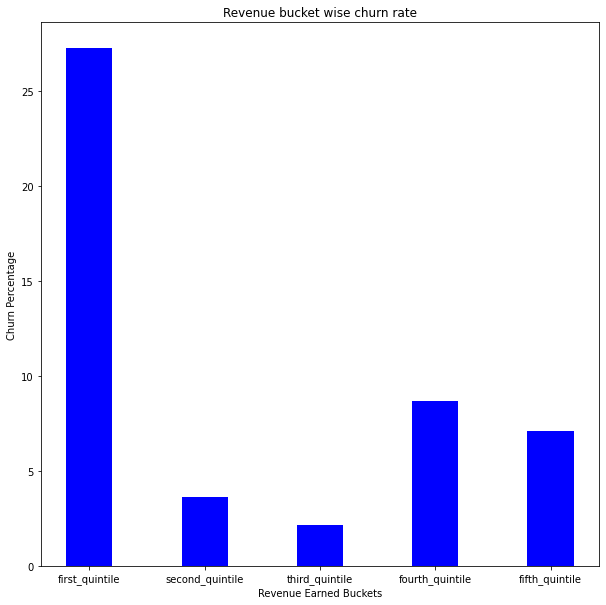

In [615]:
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
plt.bar(count_churn2021['count_group'], count_churn2021['churn_rate'], color ='blue',
        width = 0.4)
plt.xlabel("Revenue Earned Buckets")
plt.ylabel("Churn Percentage")
plt.title("Revenue bucket wise churn rate")
plt.show()

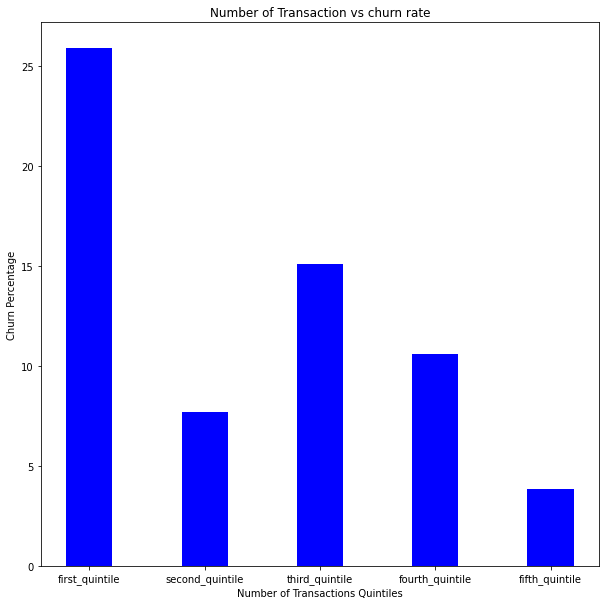

In [815]:
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
plt.bar(count_churn2020['count_group'], count_churn2020['churn_rate'], color ='blue',
        width = 0.4)
plt.xlabel("Number of Transactions Quintiles")
plt.ylabel("Churn Percentage")
plt.title("Number of Transaction vs churn rate")
plt.show()

## Importing Top selling products Information and building Item based features

In [18]:
top_sellers=top_sellers.fillna(0)
top_sellers['total_rev'] = top_sellers['2016'] + top_sellers['2017'] + top_sellers['2018'] + top_sellers['2019'] + top_sellers['2020']+ top_sellers['2021'] + top_sellers['2022']
top_sellers=top_sellers.fillna(0)

top_sellers.loc[top_sellers['total_rev'] >= 500000, 'item_type'] = 'Platinum'
top_sellers.loc[(top_sellers['total_rev'] >= 250000) & (top_sellers['total_rev'] < 500000), 'item_type'] = 'Gold'
top_sellers.loc[(top_sellers['total_rev'] >= 100000) & (top_sellers['total_rev'] < 250000), 'item_type'] = 'Silver'
top_sellers.loc[(top_sellers['total_rev'] >= 50000) & (top_sellers['total_rev'] < 100000), 'item_type'] = 'Bronze'
top_sellers.loc[(top_sellers['total_rev'] < 50000), 'item_type'] = 'Metal'
top_sellers.loc[top_sellers['total_rev'] >= 500000, 'Platinum'] = 1
top_sellers.loc[(top_sellers['total_rev'] >= 250000) & (top_sellers['total_rev'] < 500000), 'Gold'] = 1
top_sellers.loc[(top_sellers['total_rev'] >= 100000) & (top_sellers['total_rev'] < 250000), 'Silver'] = 1
top_sellers.loc[(top_sellers['total_rev'] >= 50000) & (top_sellers['total_rev'] < 100000), 'Bronze'] = 1
top_sellers.loc[(top_sellers['total_rev'] < 50000), 'Metal'] = 1
top_sellers=top_sellers.fillna(0)
top_items = top_sellers[['Row Labels','item_type','Platinum','Gold','Silver','Bronze','Metal']]
top_items = top_items.rename(columns={"Row Labels": "Item"})

#---------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx------------------------------------------#

sales = pd.merge(sales,
                 top_items,
                 on = ('Item'), 
                 how = 'left')

sales['year'] = pd.DatetimeIndex(sales['Posting Date']).year
sales = sales[sales['Platinum'].notnull()]
platinum_sales = sales.groupby('customer_time')['Platinum'].sum().reset_index()
sales_account['Platinum_products'] = platinum_sales['Platinum']
gold_sales = sales.groupby('customer_time')['Gold'].sum().reset_index()
sales_account['Gold_products'] = gold_sales['Gold']
Silver_sales = sales.groupby('customer_time')['Silver'].sum().reset_index()
sales_account['Silver_products'] = Silver_sales['Silver']
Bronze_sales = sales.groupby('customer_time')['Bronze'].sum().reset_index()
sales_account['Bronze_products'] = Bronze_sales['Bronze']
Metal_sales = sales.groupby('customer_time')['Metal'].sum().reset_index()
sales_account['Metal_products'] = Metal_sales['Metal']

sales_account['total_platinum_items'] = sales_account.groupby('Customer No')['Platinum_products'].cumsum()
sales_account['total_gold_items'] = sales_account.groupby('Customer No')['Gold_products'].cumsum()
sales_account['total_silver_items'] = sales_account.groupby('Customer No')['Silver_products'].cumsum()
sales_account['total_Bronze_items'] = sales_account.groupby('Customer No')['Bronze_products'].cumsum()
sales_account['total_Metal_items'] = sales_account.groupby('Customer No')['Metal_products'].cumsum()

#---------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx------------------------------------------#

sales_account['Platinum_Quality_Ratio'] = (sales_account['total_platinum_items'])/((sales_account['total_platinum_items'])
                                                                                   +sales_account['total_gold_items']
                                                                                   +sales_account['total_silver_items']
                                                                                   +sales_account['total_Bronze_items']
                                                                                   +sales_account['total_Metal_items'])*100

sales_account['Platinum_Gold_Quality_Ratio'] = (sales_account['total_platinum_items']+sales_account['total_gold_items'])/((sales_account['total_platinum_items'])
                                                                                   +sales_account['total_gold_items']
                                                                                   +sales_account['total_silver_items']
                                                                                   +sales_account['total_Bronze_items']
                                                                                   +sales_account['total_Metal_items'])*100

sales_account['Platinum_Quality_Ratio'] = sales_account['Platinum_Quality_Ratio']*100
sales_account['Platinum_Gold_Quality_Ratio'] = sales_account['Platinum_Gold_Quality_Ratio']*100
sales_account.loc[sales_account['total_platinum_items'] == 0, 'Platinum_bucket'] = '0'
sales_account.loc[(sales_account['total_platinum_items'] >= 1) & (sales_account['total_platinum_items'] < 5), 'Platinum_bucket'] = '1-5'
sales_account.loc[(sales_account['total_platinum_items'] >= 5), 'Platinum_bucket'] = '>5'

sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]

#---------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx------------------------------------------#

platinum_churn = sales_consolidated_lasttransaction.groupby(['Platinum_bucket','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','Platinum_bucket'])['Customer No'].nunique().reset_index()
platinum_churn = pd.merge(platinum_churn,
                 year_count,
                 on=('year','Platinum_bucket'), 
                 how='left')
platinum_churn['churn_rate'] = platinum_churn['churn_standard']/platinum_churn['Customer No']*100
platinum_churn_2021 = platinum_churn.loc[platinum_churn['year'] == 2021]

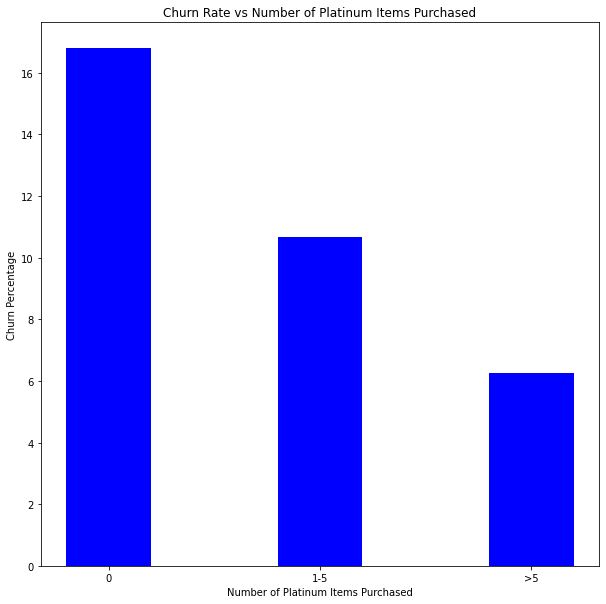

In [824]:
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
plt.bar(platinum_churn_2021['Platinum_bucket'], platinum_churn_2021['churn_rate'], color ='blue',
        width = 0.4)

plt.xlabel("Number of Platinum Items Purchased")
plt.ylabel("Churn Percentage")
plt.title("Churn Rate vs Number of Platinum Items Purchased")
plt.show()

In [19]:
sales_account.loc[sales_account['Platinum_Quality_Ratio'] == 0, 'Platinum_Quality_bucket'] = '0'
sales_account.loc[(sales_account['Platinum_Quality_Ratio'] >= 1) & (sales_account['Platinum_Quality_Ratio'] < 25), 'Platinum_Quality_bucket'] = '1-25'
sales_account.loc[(sales_account['Platinum_Quality_Ratio'] >= 25) & (sales_account['Platinum_Quality_Ratio'] <= 100), 'Platinum_Quality_bucket'] = '>25'
sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]

platinum_churn = sales_consolidated_lasttransaction.groupby(['Platinum_Quality_bucket','year'])['churn_standard'].sum().reset_index()
year_count = sales_account.groupby(['year','Platinum_Quality_bucket'])['Customer No'].nunique().reset_index()
platinum_churn = pd.merge(platinum_churn,
                 year_count,
                 on=('year','Platinum_Quality_bucket'), 
                 how='left')
platinum_churn['churn_rate'] = platinum_churn['churn_standard']/platinum_churn['Customer No']*100

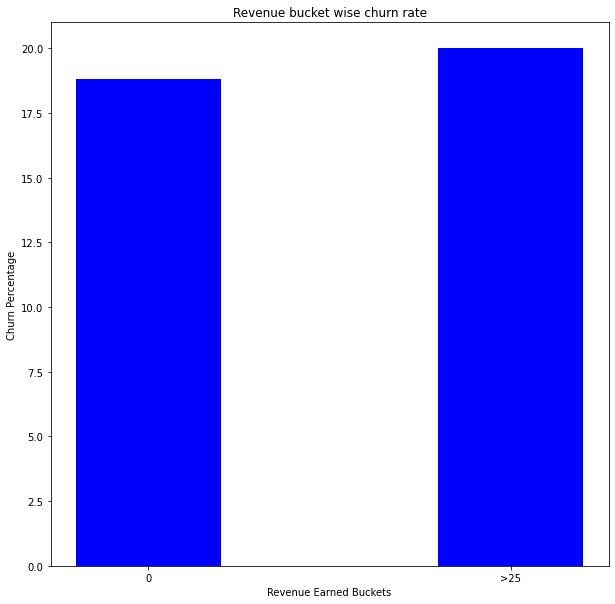

In [80]:
platinum_churn_2021 = platinum_churn.loc[platinum_churn['year'] == 2021]
fig = plt.figure(figsize = (10, 10))
# creating the bar plot
plt.bar(platinum_churn_2021['Platinum_Quality_bucket'], platinum_churn_2021['churn_rate'], color ='blue',
        width = 0.4)
plt.xlabel("Revenue Earned Buckets")
plt.ylabel("Churn Percentage")
plt.title("Revenue bucket wise churn rate")
plt.show()

##### Creating tenure feature

In [20]:
first_sale = sales_account.loc[sales_account['count'] == 1][['Customer No','Posting Date']]
first_sale = first_sale.rename(columns={"Posting Date": "first_sale_date"})
sales_account = pd.merge(sales_account,
                 first_sale,
                 on=('Customer No'), 
                 how='left')
sales_account['tenure'] = sales_account['Posting Date'] - sales_account['first_sale_date']
sales_account['tenure'] = sales_account['tenure']/np.timedelta64(1,'D')
sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]

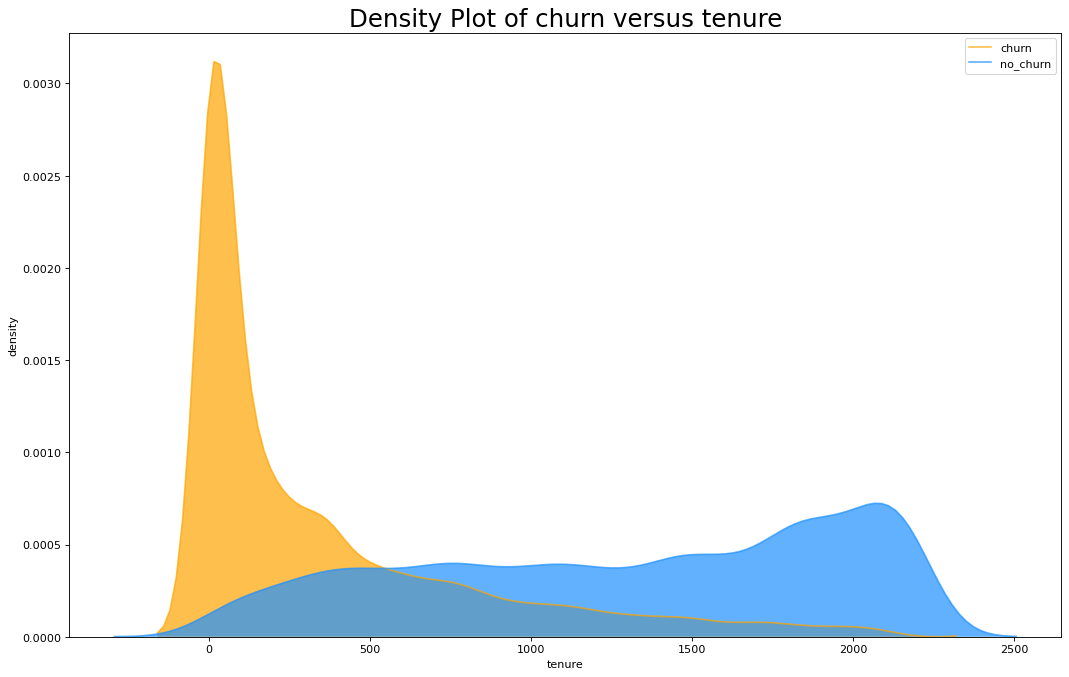

In [83]:
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(sales_consolidated_lasttransaction.loc[sales_consolidated_lasttransaction['churn_standard'] == 1, "tenure"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(sales_consolidated_lasttransaction.loc[sales_consolidated_lasttransaction['churn_standard'] == 0, "tenure"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)
# Decoration
plt.title('Density Plot of churn versus tenure', fontsize=22)
plt.ylabel('density')
plt.xlabel('tenure')
plt.legend()
plt.show()

Churned customers have a very less tenure. Non-churned customers have much larger tenure

### Feature Engineering

##### Average Quantity Ordered, Total Quantity, Gradient Quantity, Total Cost and Average Cost

In [21]:
#Master data set for features
features = sales_account
#1- Average Quantity of items ordered by the customer
features['AvgQuantity'] = (
    features.groupby('Customer No')['Quantity Ordered'].apply(lambda x: x.expanding().mean()))

#2- Total number of items purchased by the customer till date
features['TotalQuantity'] = (
    features.groupby('Customer No')['Quantity Ordered'].cumsum())

#3- Gradient of the number of products ordered by customer
features['GradientQuantity'] = (
    features.groupby('Customer No')['Quantity Ordered'].diff())

#5- Total revenue generated by the customer to date/ CLV
features['TotalCost'] = (
    features.groupby('Customer No')['Line Item Amount'].cumsum())

#6- Average revenue of the customer (Line amount/total orders) 
features['AvgCost'] = (
    features.groupby('Customer No')['Line Item Amount'].apply(lambda x: x.expanding().mean()))


#------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx---------------------------------------------#

##### Net Purchasing Interval Increasing or Decreasing Variable
sales_account.loc[sales_account['Customer No'] == sales_account['Customer No'].shift(1),'last_order_date'] = sales_account['Posting Date'].shift(1) 
sales_account['time_between_sales_trend'] = sales_account['Posting Date'] - sales_account['last_order_date']
sales_account['time_between_sales_trend'] = sales_account['time_between_sales_trend']/np.timedelta64(1,'D')
sales_account['time_between_sales_trend'] = (
    sales_account.groupby('Customer No')['time_between_sales_trend'].diff())
sales_account['time_between_sales_trend'] = (
    sales_account.groupby('Customer No')['time_between_sales_trend'].cumsum())


#------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx---------------------------------------------#


##### Net Sales Revenue Increasing or Decreasing
sales_account['Gradient_Revenue'] = (
    features.groupby('Customer No')['Line Item Amount'].diff())
sales_account['Gradient_Revenue'] = (
    sales_account.groupby('Customer No')['Gradient_Revenue'].cumsum())

#------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx---------------------------------------------#

# Customer Specific top Items
x=pd.DataFrame(sales.groupby(['Customer No'])['Item'].value_counts().rename('Count').reset_index()) 
x= x.drop_duplicates('Customer No')
features =pd.merge(features, x, on=('Customer No'), how='left')
features = features.rename(columns={'Item':'Customer_specific_pop.Item', 'Count':'Popular_item_count'})
y = pd.DataFrame(sales.groupby(['Customer No'])['Department Dim Description'].value_counts().rename('Count').reset_index()) 
y= y.drop_duplicates('Customer No')
features =pd.merge(features, y, on=('Customer No'), how='left')
features = features.rename(columns={'Department Dim Description':'top_department_dims', 'Count':'popular__department_dims_count'})
z = pd.DataFrame(sales.groupby(['Customer No'])['Product Group Description'].value_counts().rename('Count').reset_index()) 
z= z.drop_duplicates('Customer No')
features =pd.merge(features, z, on=('Customer No'), how='left')
features = features.rename(columns={'Product Group Description':'top_product_dims', 'Count':'popular_dims_count'})
sales_account = features

u = pd.DataFrame(sales.groupby(['Customer No','Department Dim Description'])['Item'].count().reset_index())
u['product_lines'] = pd.DataFrame(u[['Customer No','Department Dim Description']].groupby(['Customer No'])['Department Dim Description'].transform(lambda x : ' | '.join(x)))
u= u.drop_duplicates('Customer No')
u.drop(['Department Dim Description','Item'], axis = 1, inplace = True) 

#------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx---------------------------------------------#


##### No. of Managers & Consolidated Silverpop score
contact1 = contact1.rename(columns={"AccountNumber": "Customer No"})
contact1 = contact1[['Customer No','No.Of Managers','Consolidated_Silverpop']]
sales_account = pd.merge(sales_account,
                 contact1,
                 on=('Customer No'), 
                 how='left')

#------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx---------------------------------------------#


##### Percent DGOP contacts
contact2 = contact.groupby('Acct_Number__c').agg(NoofContacts_DGOP=('Job_Function_LM__c', 'value_counts')).reset_index()
contact3=contact2.groupby('Acct_Number__c').agg(TotalContacts=('NoofContacts_DGOP', 'sum')).reset_index()
contact_DGOP=contact2.loc[(contact2['Job_Function_LM__c']=="DG") | (contact2['Job_Function_LM__c']=="OP")]
contact_DGOP=contact_DGOP.groupby('Acct_Number__c').agg(Total_DGOP_Contacts=('NoofContacts_DGOP', 'sum')).reset_index()
contact_DGOP=contact_DGOP.merge(contact3,on=('Acct_Number__c'),how=('left'))
contact_DGOP['Perc_DGOP']=((contact_DGOP['Total_DGOP_Contacts'])/(contact_DGOP['TotalContacts'])*100)

sales_account = sales_account.merge(contact_DGOP,left_on=('Customer No'),right_on=('Acct_Number__c'),how=('left'))

#------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx---------------------------------------------#

##### Compliance score of family and family data join with sales_account
family['Family_Name__c'] = family['Family_Name__c'].astype(str)
family['Family_Segmentation__c'] = family['Family_Segmentation__c'].fillna('not_compliant')
sub ='Safely'
sub2 = 'Basically'
sub3 = 'not_compliant'
family.loc[family["Family_Segmentation__c"].str.contains(sub),'compliance_score'] = 1
family.loc[family["Family_Segmentation__c"].str.contains(sub2),'compliance_score'] = 2
family.loc[family["Family_Segmentation__c"].str.contains(sub3),'compliance_score'] = 3
del family['Tier_Note__c']
sales_account['family_code'] = sales_account['FamilyCode_FNT__c'].astype(str).str.split('.').str[0]
sales_account = sales_account.merge(family,left_on=('family_code'),right_on=('Family_Name__c'),how=('left'))

del sales_account['ZI_Industry__c']
industry = account[['Customer No','ZI_Industry__c']]
sales_account = sales_account.merge(industry,left_on=('Customer No'),right_on=('Customer No'),how=('left'))
sales_account.loc[sales_account['ZI_Industry__c'].isnull(),'ZI_Industry__c'] = sales_account['Family_Industry_Description_New__c']
sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]

#------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx---------------------------------------------#

##### Item Diversity Index and Dept Diversity Index
sales_item = sales.groupby(['customer_time'])['Item'].nunique().reset_index()
sales_dept = sales.groupby('customer_time')['Department Dim Description'].nunique().reset_index()
sales_item = sales_item.rename(columns={'Item': "item_diversity_index"})
sales_dept = sales_dept.rename(columns={'Department Dim Description': "dept_diversity_index"})
sales_account = sales_account.merge(sales_item, on = ('customer_time'),how=('left'))
sales_account = sales_account.merge(sales_dept, on = ('customer_time'),how=('left'))
sales_account['cumulative_item_count'] = sales_account.groupby('Customer No')['item_diversity_index'].cumsum()
sales_account['cumulative_dept_count'] = sales_account.groupby('Customer No')['dept_diversity_index'].cumsum()
sales_account['item_diversity_index'] = sales_account['cumulative_item_count']/sales_account['count']
sales_account['dept_diversity_index'] = sales_account['cumulative_dept_count']/sales_account['count']
sales_account.drop(['cumulative_item_count', 'cumulative_dept_count'], axis=1, inplace=True)
sales_consolidated_lasttransaction = sales_account.loc[(sales_account['last'] == 'true')]
sales_consolidated_lasttransaction =pd.merge(sales_consolidated_lasttransaction, u, on=('Customer No'), how='left')


#------------------------------------xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx---------------------------------------------#

### Date Churned
sales_consolidated_lasttransaction['date_churned'] = sales_consolidated_lasttransaction['Posting Date'] +  pd.to_timedelta(sales_consolidated_lasttransaction['time_to_churn_standard'], unit='D')
EndDate = date.today() + timedelta(days=10)


In [22]:
## Output File for Marketing
output_data = sales_consolidated_lasttransaction[['Customer No','churn_standard','date_churned','Tier__c','cumulative_sum_revenue','ZI_Industry__c',
                                   'Perc_DGOP','product_lines','Customer_specific_pop.Item','top_product_dims',
                                    'top_department_dims']]

In [23]:
IIT_churn_master_dataset = sales_account
IIT_churn_customer_master_dataset = sales_consolidated_lasttransaction
IIT_churn_master_dataset = IIT_churn_master_dataset.drop(['Quantity Ordered','Line Item Amount','next_order_date','block',
                       'last','year','Id_x','CreatedDate_x','LastActivityDate','FamilyCode_FNT__c',
                       'Platinum_products','Gold_products','Silver_products','Bronze_products','Metal_products',
                       'first_sale_date','GradientQuantity','Acct_Number__c','family_code','Id_y','CreatedDate_y',
                       'Family_Name__c','last_order_date'],axis = 1)
IIT_churn_customer_master_dataset = IIT_churn_customer_master_dataset.drop(['customer_time','Quantity Ordered','Line Item Amount','next_order_date','block',
                       'last','year','Id_x','CreatedDate_x','LastActivityDate','FamilyCode_FNT__c','count_group',
                       'Platinum_products','Gold_products','Silver_products','Bronze_products','Metal_products',
                       'first_sale_date','GradientQuantity','Acct_Number__c','family_code','Id_y','CreatedDate_y',
                       'Family_Name__c','last_order_date'],axis = 1)

# Categorical Variables

## Count Group 

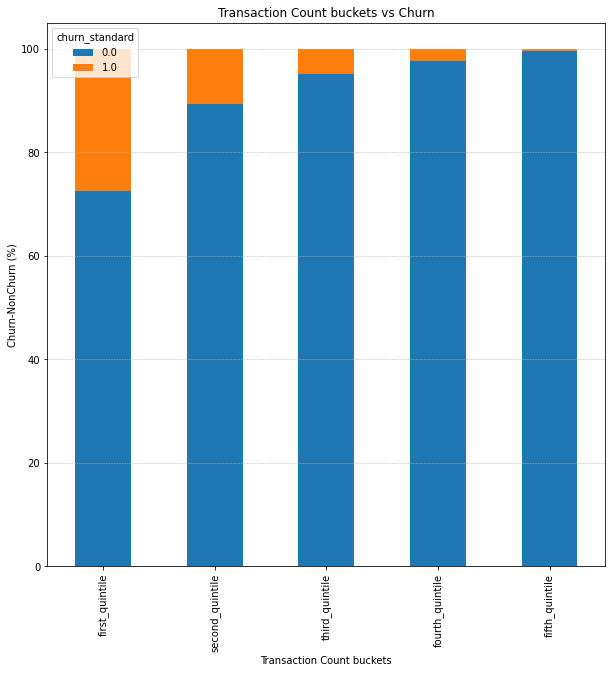

In [27]:
IIT_churn_master_dataset['count_group'] = sales_account['count_group']
df_group = IIT_churn_master_dataset.groupby(['count_group','churn_standard'])['Customer No'].count().reset_index()
df_group_pivot = df_group.pivot_table('Customer No', ['count_group'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (10, 10))
plt.title("Transaction Count buckets vs Churn")
plt.xlabel("Transaction Count buckets")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

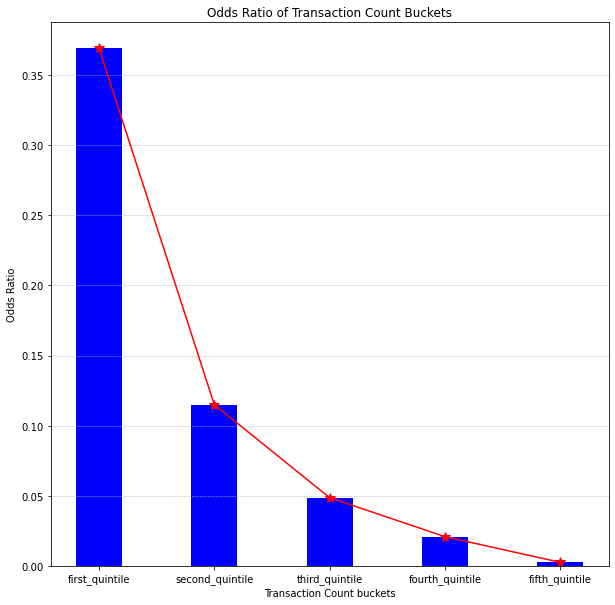

In [1540]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['count_group'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)
plt.title("Odds Ratio of Transaction Count Buckets")
plt.xlabel("Transaction Count buckets")
plt.ylabel("Odds Ratio")

plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Variable Score : 9

## Coverage_Priority__c

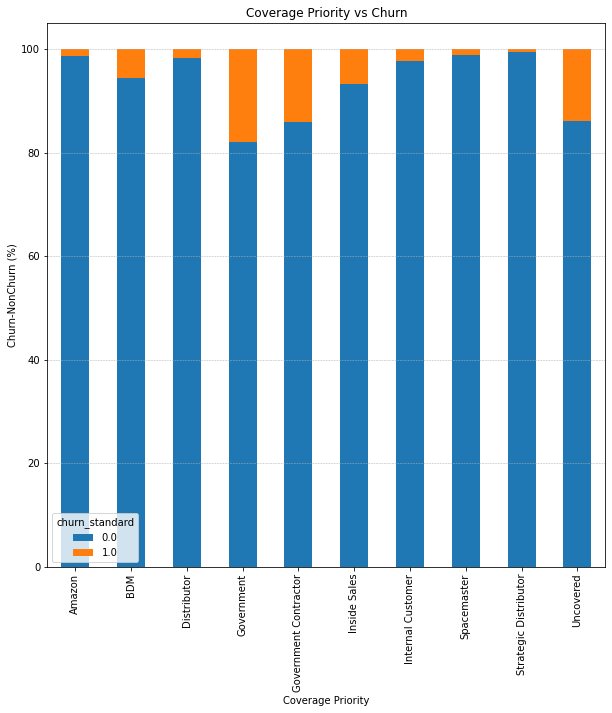

In [1541]:
df_group = IIT_churn_master_dataset.groupby(['Coverage_Priority__c','churn_standard'])['Customer No'].count().reset_index()
df_group_pivot = df_group.pivot_table('Customer No', ['Coverage_Priority__c'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, figsize = (10, 10))
plt.title("Coverage Priority vs Churn")
plt.xlabel("Coverage Priority")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

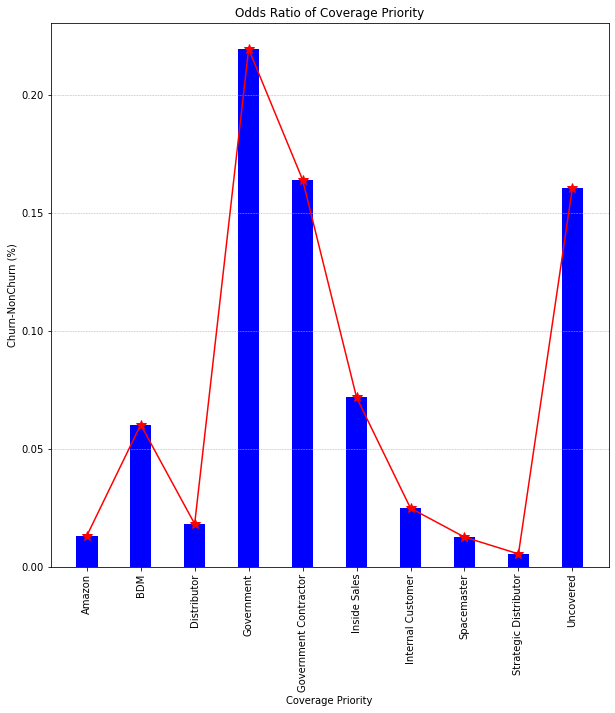

In [1544]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['Coverage_Priority__c'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)
plt.title("Odds Ratio of Coverage Priority")
plt.xlabel("Coverage Priority")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Variable Score : 7

## Client_revenue

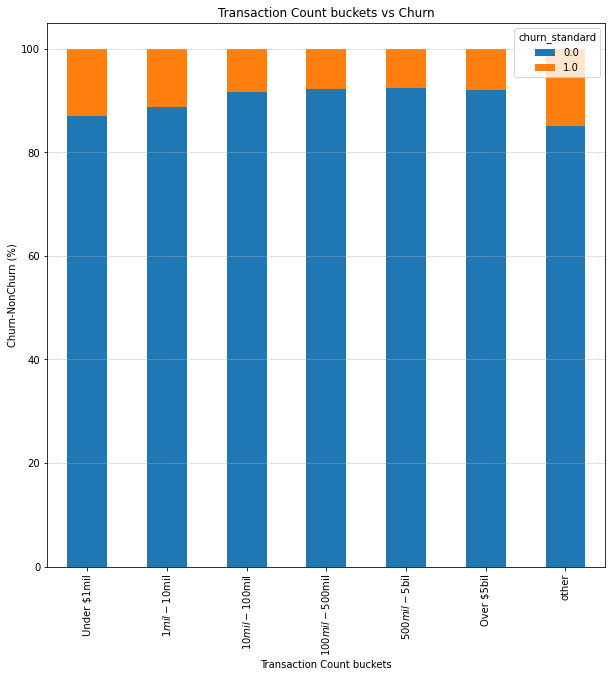

In [26]:
# Replacing Missing values
IIT_churn_master_dataset['Client_revenue'] = sales_account['Client_revenue']
IIT_churn_master_dataset['Client_revenue'].fillna('other', inplace = True)
df_group = IIT_churn_master_dataset.groupby(['Client_revenue','churn_standard'])['Customer No'].count().reset_index()
df_group['Client_revenue'] = df_group['Client_revenue'].astype('category')
df_group['Client_revenue'] = df_group['Client_revenue'].cat.reorder_categories(['Under $1mil','$1mil-$10mil','$10mil-$100mil','$100mil-$500mil','$500mil-$5bil','Over $5bil','other'])
df_group_pivot = df_group.pivot_table('Customer No', ['Client_revenue'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, figsize = (10, 10))
plt.title("Transaction Count buckets vs Churn")
plt.xlabel("Transaction Count buckets")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

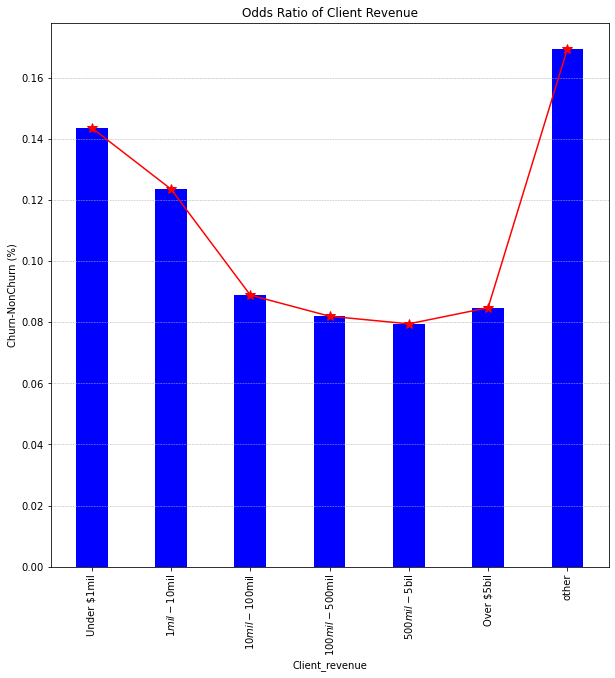

In [1584]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['Client_revenue'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)
plt.title("Odds Ratio of Client Revenue")
plt.xlabel("Client_revenue")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Variable Score : 5

## Family_Industry_Description_New__c

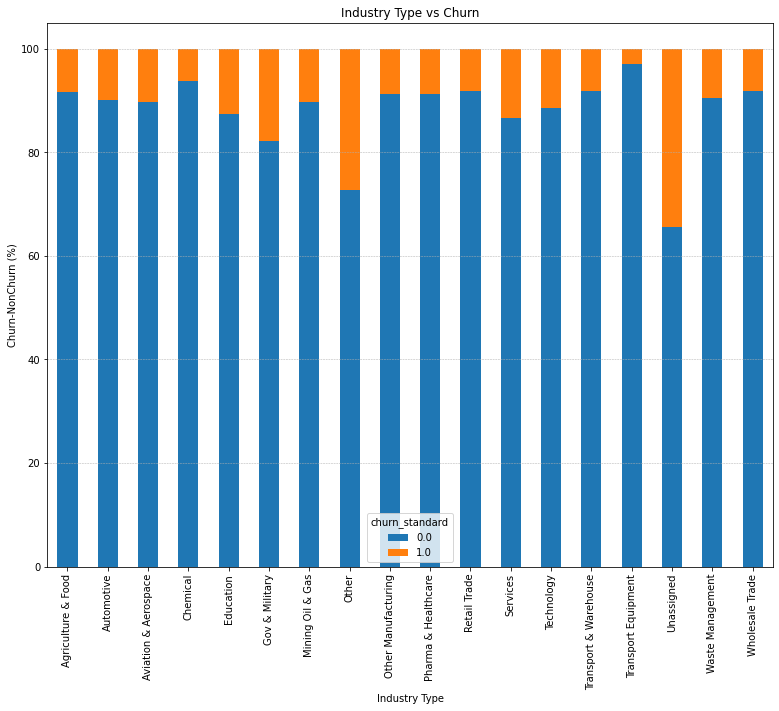

In [25]:
IIT_churn_master_dataset['Family_Industry_Description_New__c'].fillna('Unassigned', inplace = True)
df_group = IIT_churn_master_dataset.groupby(['Family_Industry_Description_New__c','churn_standard'])['Customer No'].count().reset_index()
df_group_pivot = df_group.pivot_table('Customer No', ['Family_Industry_Description_New__c'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("Industry Type vs Churn")
plt.xlabel("Industry Type")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

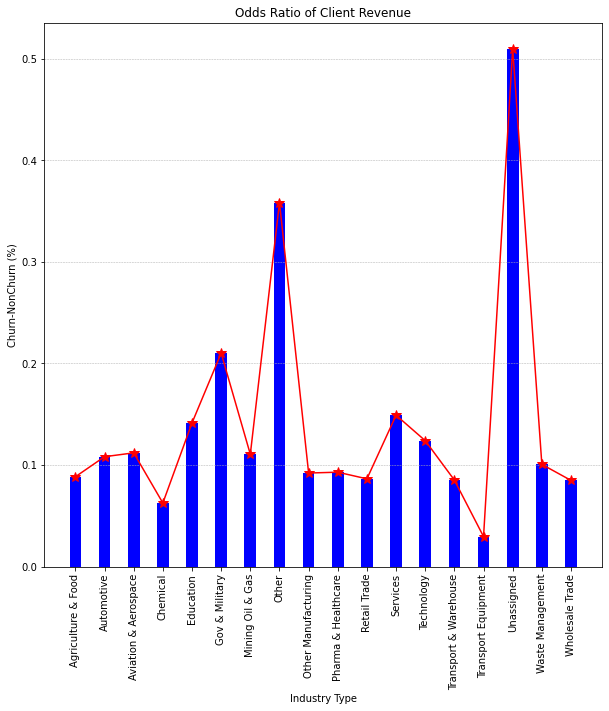

In [1613]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['Family_Industry_Description_New__c'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)
plt.title("Odds Ratio of Industry Type")
plt.xlabel("Industry Type")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Variable Score : 5

## compliance_score

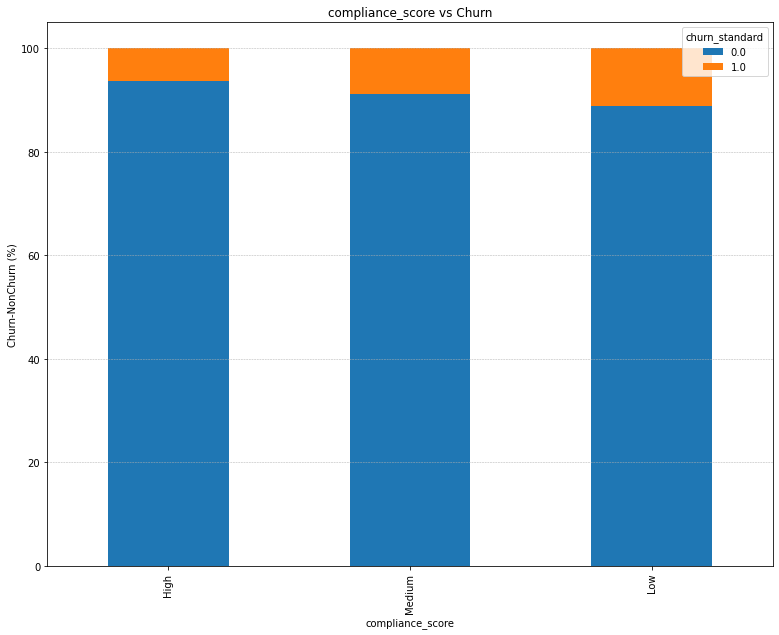

In [1630]:
IIT_churn_master_dataset['compliance_score'].fillna(3, inplace = True)
IIT_churn_master_dataset["compliance_score"].replace({1: "High", 2: "Medium", 3:"Low"}, inplace=True)
df_group = IIT_churn_master_dataset.groupby(['compliance_score','churn_standard'])['Customer No'].count().reset_index()
df_group['compliance_score'] = df_group['compliance_score'].astype('category')
df_group['compliance_score'] = df_group['compliance_score'].cat.reorder_categories(['High','Medium','Low'])
df_group_pivot = df_group.pivot_table('Customer No', ['compliance_score'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("compliance_score vs Churn")
plt.xlabel("compliance_score")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

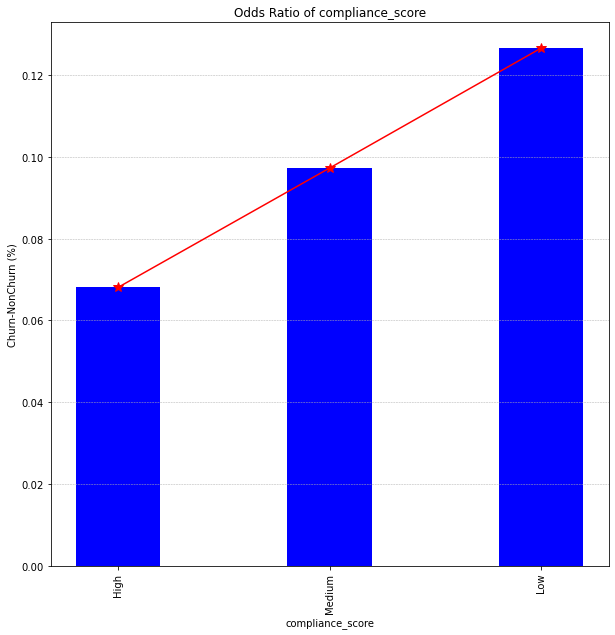

In [1632]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['compliance_score'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Odds Ratio of compliance_score")
plt.xlabel("compliance_score")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Variable Score: 7

## Territory__c

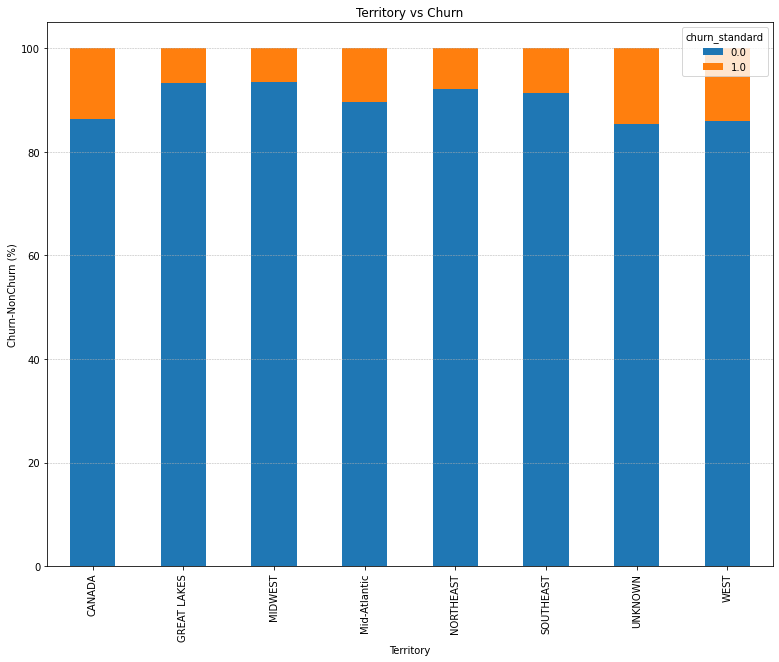

In [28]:
IIT_churn_master_dataset['Territory__c'].fillna('UNKNOWN', inplace = True)
df_group = IIT_churn_master_dataset.groupby(['Territory__c','churn_standard'])['Customer No'].count().reset_index()
df_group_pivot = df_group.pivot_table('Customer No', ['Territory__c'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("Territory vs Churn")
plt.xlabel("Territory")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

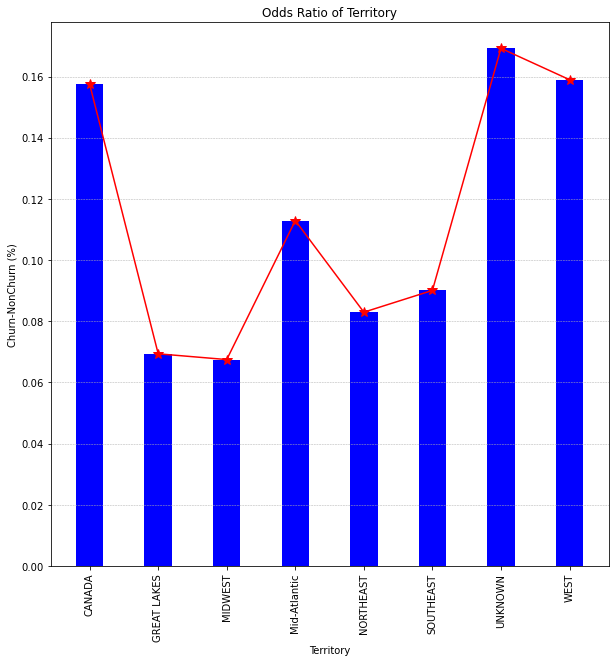

In [1643]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['Territory__c'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Odds Ratio of Territory")
plt.xlabel("Territory")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Variable Score: 6

## Platinum_Quality_bucket

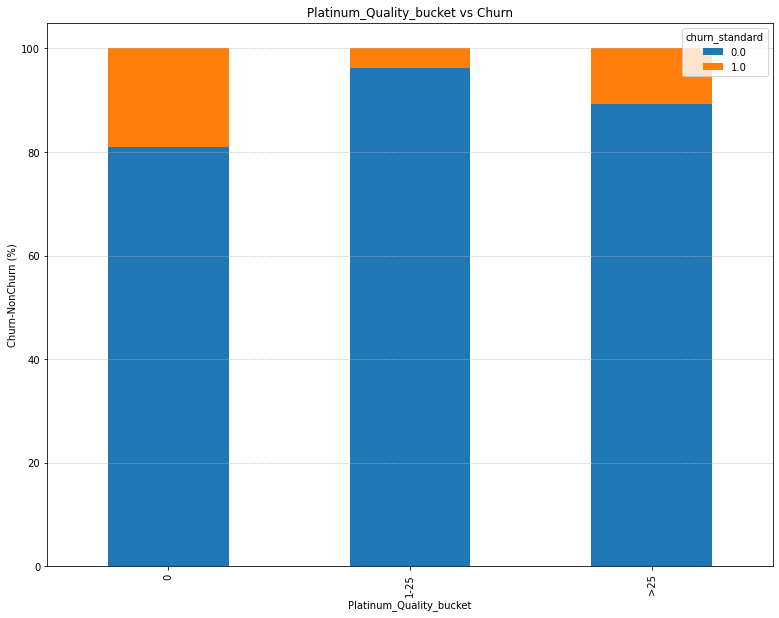

In [1651]:
df_group = IIT_churn_master_dataset.groupby(['Platinum_Quality_bucket','churn_standard'])['Customer No'].count().reset_index()
df_group_pivot = df_group.pivot_table('Customer No', ['Platinum_Quality_bucket'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("Platinum_Quality_bucket vs Churn")
plt.xlabel("Platinum_Quality_bucket")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

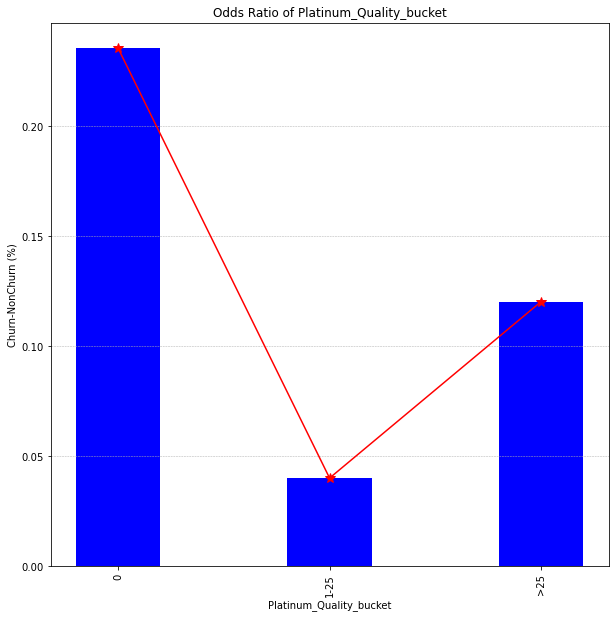

In [1652]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['Platinum_Quality_bucket'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Odds Ratio of Platinum_Quality_bucket")
plt.xlabel("Platinum_Quality_bucket")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Variable score : 7

# Continuous variables

## Platinum_Quality_Ratio

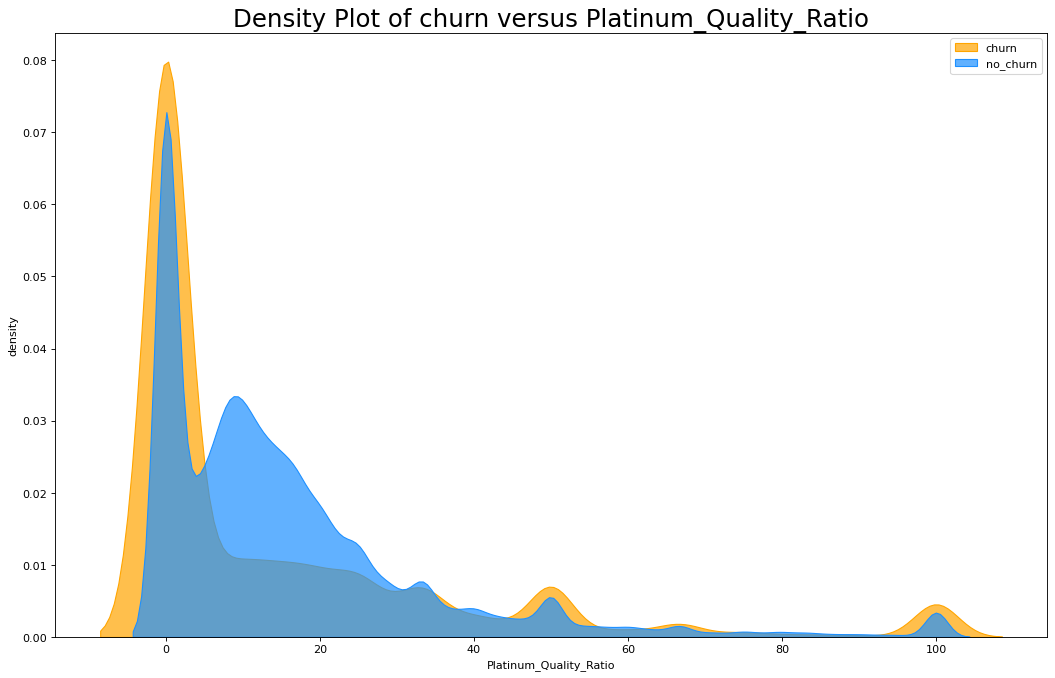

In [1656]:
IIT_churn_master_dataset_sub = IIT_churn_master_dataset[['churn_standard','Platinum_Quality_Ratio']]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[IIT_churn_master_dataset_sub['churn_standard'] == 1, "Platinum_Quality_Ratio"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[IIT_churn_master_dataset_sub['churn_standard'] == 0, "Platinum_Quality_Ratio"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)

# Decoration
plt.title('Density Plot of churn versus Platinum_Quality_Ratio', fontsize=22)
plt.ylabel('density')
plt.xlabel('Platinum_Quality_Ratio')
plt.legend()
plt.show()

Conclusion : The variable looks promising. Score: 6

## Platinum_Gold_Quality_Ratio

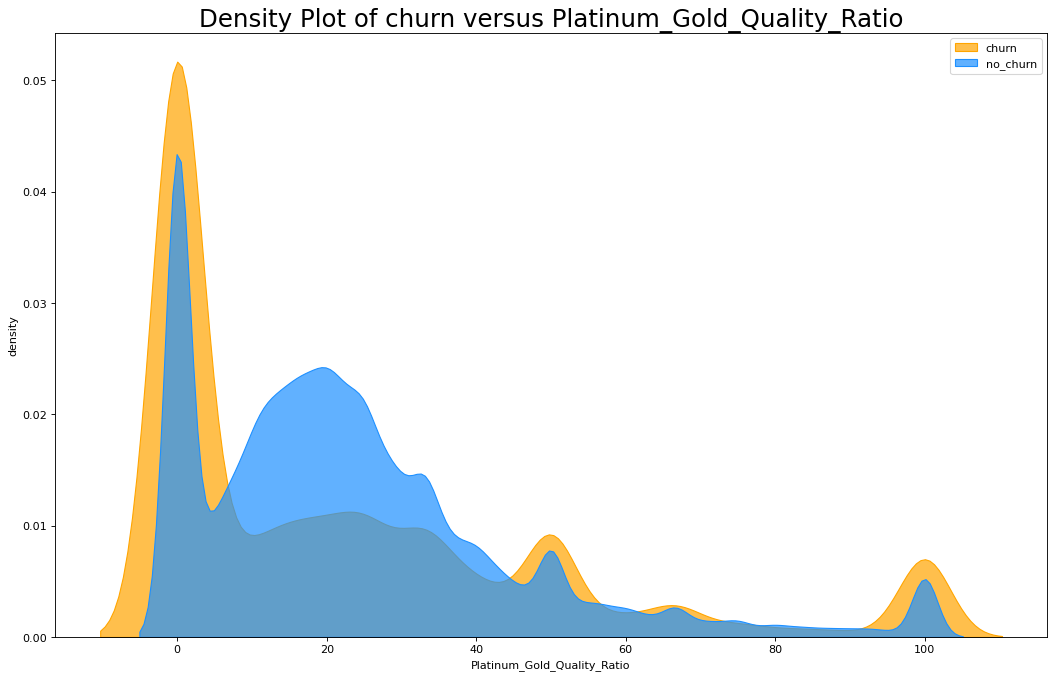

In [1659]:
IIT_churn_master_dataset_sub = IIT_churn_master_dataset[['churn_standard','Platinum_Gold_Quality_Ratio']]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[IIT_churn_master_dataset_sub['churn_standard'] == 1, "Platinum_Gold_Quality_Ratio"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[IIT_churn_master_dataset_sub['churn_standard'] == 0, "Platinum_Gold_Quality_Ratio"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)

# Decoration
plt.title('Density Plot of churn versus Platinum_Gold_Quality_Ratio', fontsize=22)
plt.ylabel('density')
plt.xlabel('Platinum_Gold_Quality_Ratio')
plt.legend()
plt.show()

Conclusion: This one looks even more promising than the last one.
Score: 6.5

## total_platinum_gold_items_per_transaction

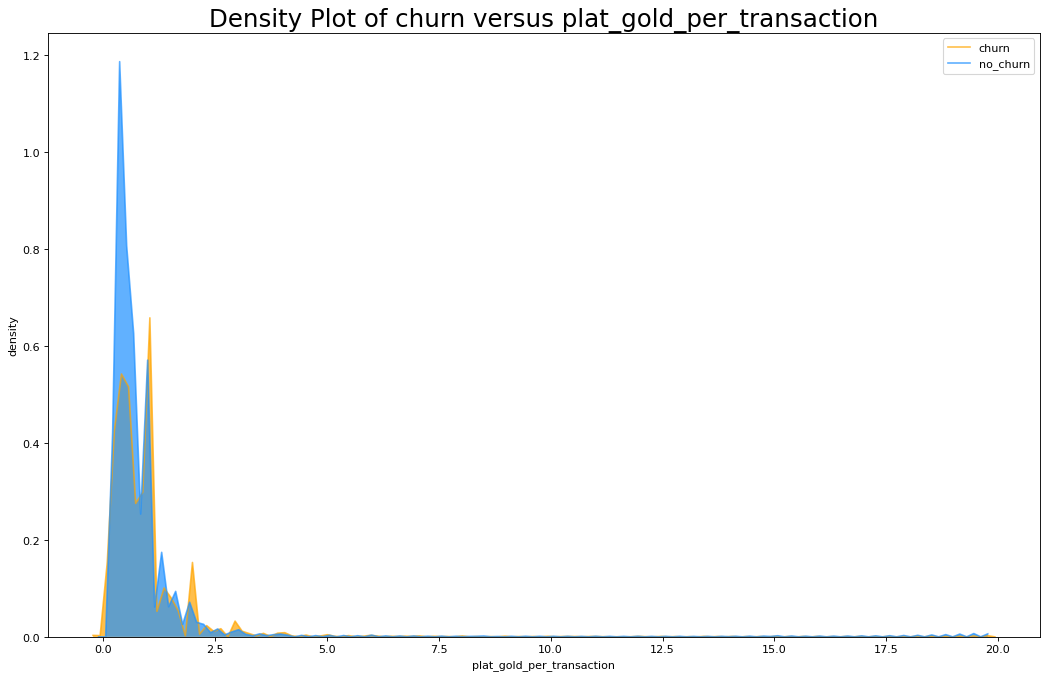

In [29]:
IIT_churn_master_dataset['plat_gold_per_transaction'] = (IIT_churn_master_dataset['total_platinum_items'] + IIT_churn_master_dataset['total_gold_items'])/IIT_churn_master_dataset['count']
IIT_churn_master_dataset['plat_gold_per_transaction'] = (IIT_churn_master_dataset['total_platinum_items'] + IIT_churn_master_dataset['total_gold_items'])/IIT_churn_master_dataset['count']
IIT_churn_master_dataset_sub = IIT_churn_master_dataset[['plat_gold_per_transaction','churn_standard']]

plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 1) & (IIT_churn_master_dataset_sub['plat_gold_per_transaction'] < 20) , "plat_gold_per_transaction"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 0) & (IIT_churn_master_dataset_sub['plat_gold_per_transaction'] < 20), "plat_gold_per_transaction"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)
plt.title('Density Plot of churn versus plat_gold_per_transaction', fontsize=22)
plt.ylabel('density')
plt.xlabel('plat_gold_per_transaction')
plt.legend()
plt.show()

Score: 6.5

## Gradient_Revenue

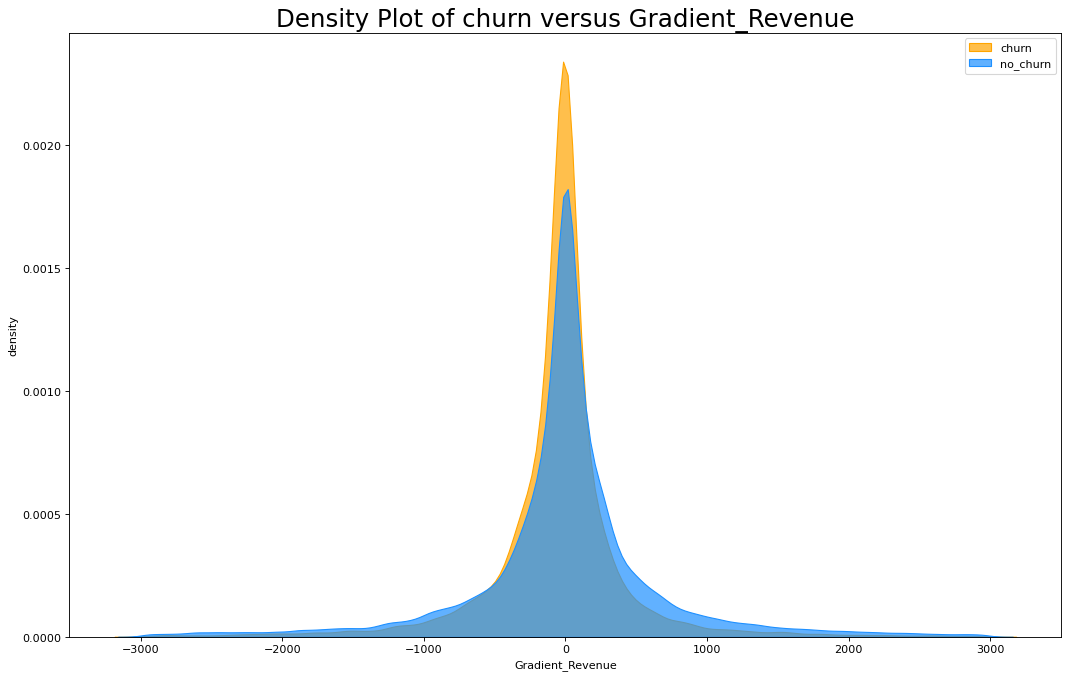

In [1670]:
IIT_churn_master_dataset_sub = IIT_churn_master_dataset[['Gradient_Revenue','churn_standard']]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 1) & (IIT_churn_master_dataset_sub['Gradient_Revenue'] < 3000) & (IIT_churn_master_dataset_sub['Gradient_Revenue'] > -3000), "Gradient_Revenue"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 0)& (IIT_churn_master_dataset_sub['Gradient_Revenue'] < 3000) & (IIT_churn_master_dataset_sub['Gradient_Revenue'] > -3000) , "Gradient_Revenue"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)

plt.title('Density Plot of churn versus Gradient_Revenue', fontsize=22)
plt.ylabel('density')
plt.xlabel('Gradient_Revenue')
plt.legend()
plt.show()

Score: 5

Making buckets of gradient rev

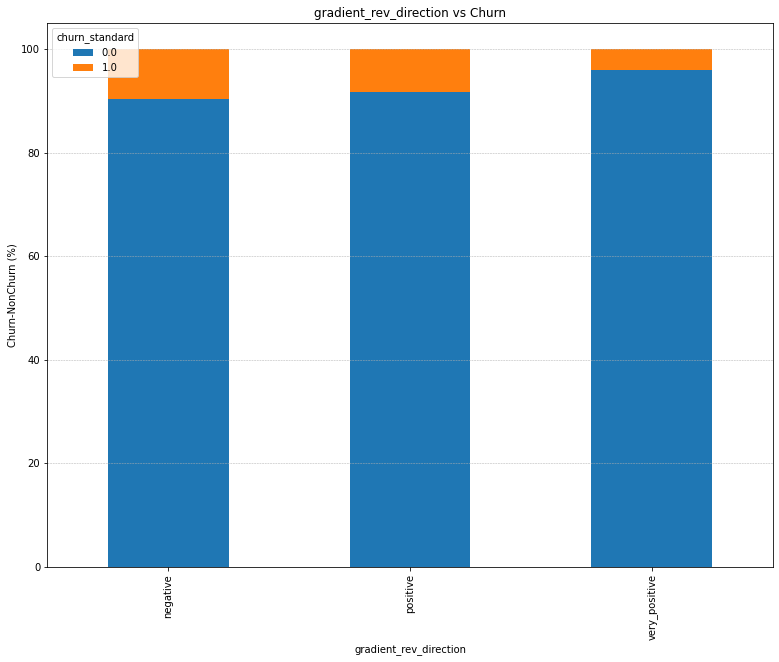

In [30]:
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['Gradient_Revenue'] <= 0),'gradient_rev_direction'] = 'negative'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['Gradient_Revenue'] > 0) & (IIT_churn_master_dataset['Gradient_Revenue'] < 500),'gradient_rev_direction'] = 'positive'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['Gradient_Revenue'] >= 500),'gradient_rev_direction'] = 'very_positive'

df_group = IIT_churn_master_dataset.groupby(['gradient_rev_direction','churn_standard'])['Customer No'].count().reset_index()
df_group_pivot = df_group.pivot_table('Customer No', ['gradient_rev_direction'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("gradient_rev_direction vs Churn")
plt.xlabel("gradient_rev_direction")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

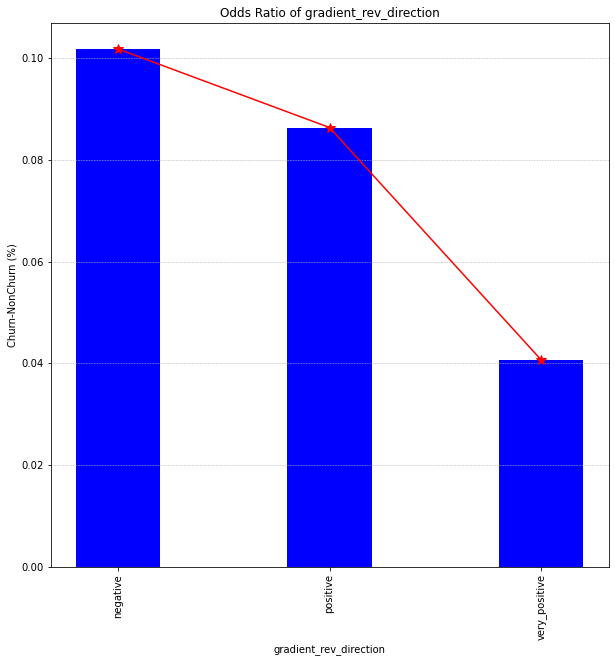

In [1682]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['gradient_rev_direction'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Odds Ratio of gradient_rev_direction")
plt.xlabel("gradient_rev_direction")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")

plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Score: 8

## item_diversity_index

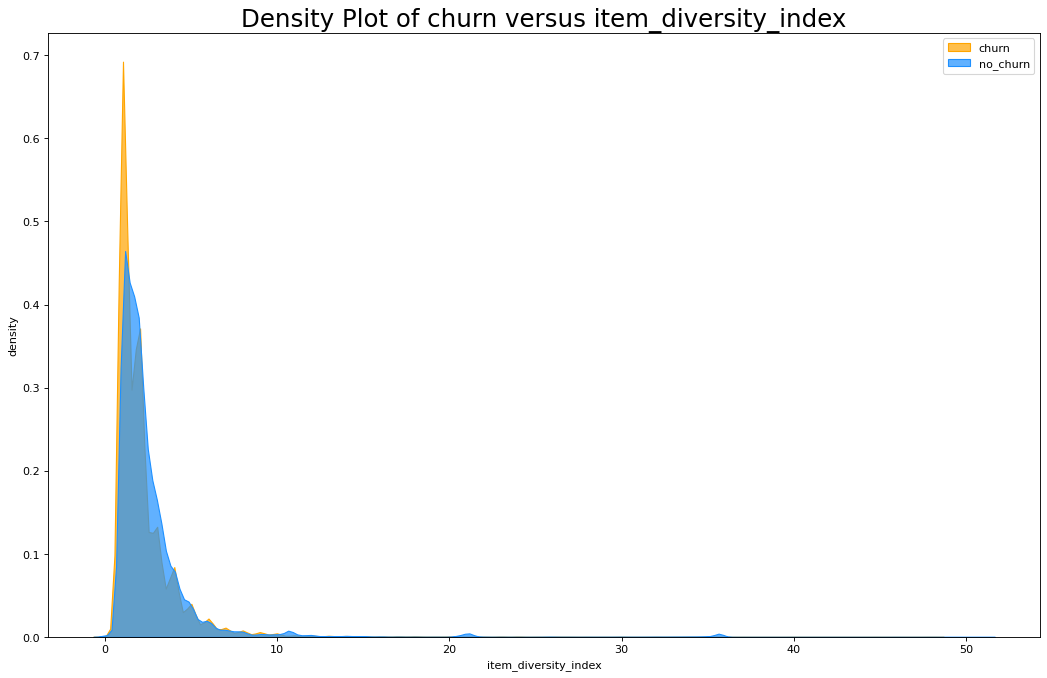

In [1671]:
IIT_churn_master_dataset_sub = IIT_churn_master_dataset[['item_diversity_index','churn_standard']]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 1), "item_diversity_index"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 0), "item_diversity_index"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)

# Decoration
plt.title('Density Plot of churn versus item_diversity_index', fontsize=22)
plt.ylabel('density')
plt.xlabel('item_diversity_index')
plt.legend()
plt.show()

score: 6

Making buckets of item diversity index

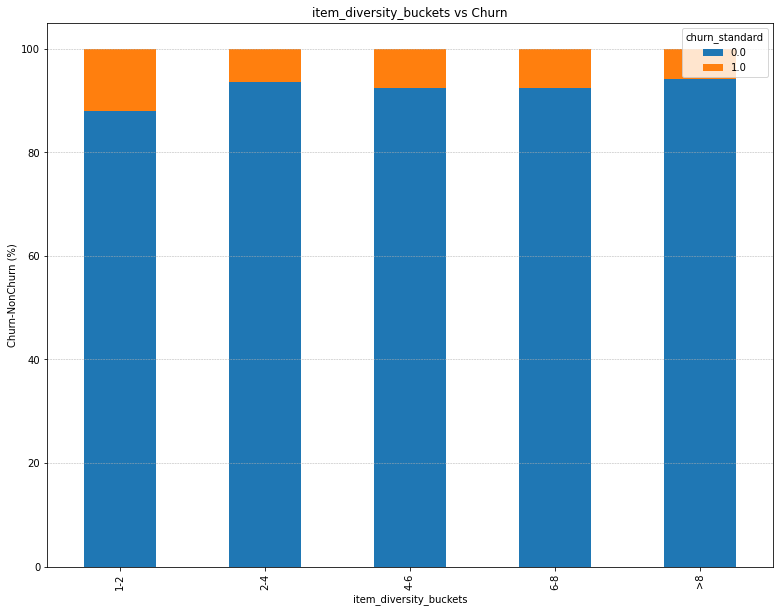

In [31]:
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['item_diversity_index'] > 0) & (IIT_churn_master_dataset['item_diversity_index'] <= 2),'item_diversity_buckets'] = '1-2'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['item_diversity_index'] > 2) & (IIT_churn_master_dataset['item_diversity_index'] <= 4),'item_diversity_buckets'] = '2-4'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['item_diversity_index'] > 4) & (IIT_churn_master_dataset['item_diversity_index'] <= 6),'item_diversity_buckets'] = '4-6'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['item_diversity_index'] > 6) & (IIT_churn_master_dataset['item_diversity_index'] <= 8),'item_diversity_buckets'] = '6-8'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['item_diversity_index'] > 8),'item_diversity_buckets'] = '>8'

df_group = IIT_churn_master_dataset.groupby(['item_diversity_buckets','churn_standard'])['Customer No'].count().reset_index()
df_group_pivot = df_group.pivot_table('Customer No', ['item_diversity_buckets'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("item_diversity_buckets vs Churn")
plt.xlabel("item_diversity_buckets")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

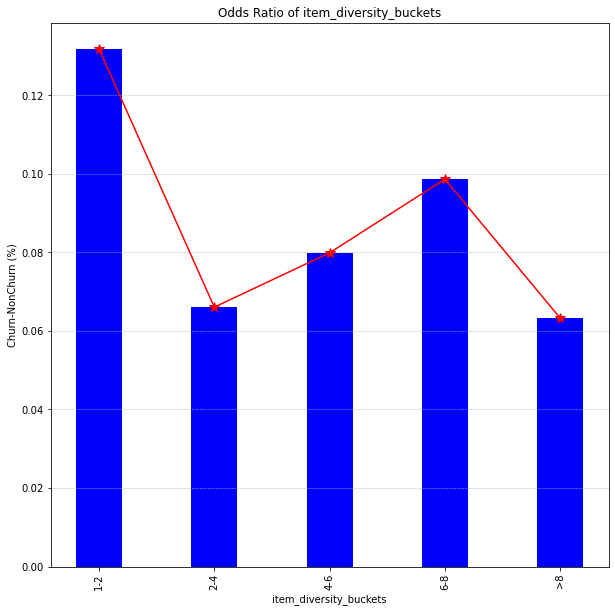

In [1686]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['item_diversity_buckets'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Odds Ratio of item_diversity_buckets")
plt.xlabel("item_diversity_buckets")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")

plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Score: 3

## time_between_sales_trend

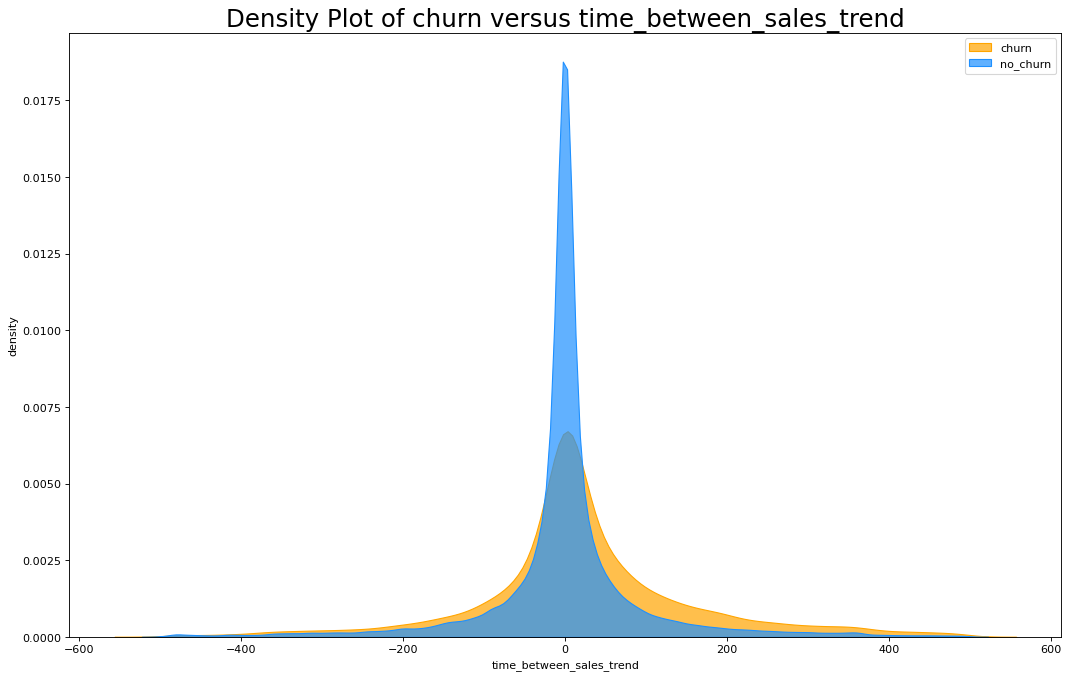

In [1689]:
IIT_churn_master_dataset_sub = IIT_churn_master_dataset[['time_between_sales_trend','churn_standard']]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 1) & (IIT_churn_master_dataset_sub['time_between_sales_trend'] < 500) & (IIT_churn_master_dataset_sub['time_between_sales_trend'] > -500), "time_between_sales_trend"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 0) & (IIT_churn_master_dataset_sub['time_between_sales_trend'] < 500) & (IIT_churn_master_dataset_sub['time_between_sales_trend'] > -500), "time_between_sales_trend"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)

# Decoration
plt.title('Density Plot of churn versus time_between_sales_trend', fontsize=22)
plt.ylabel('density')
plt.xlabel('time_between_sales_trend')
plt.legend()
plt.show()

Score: 7.5

Making buckets

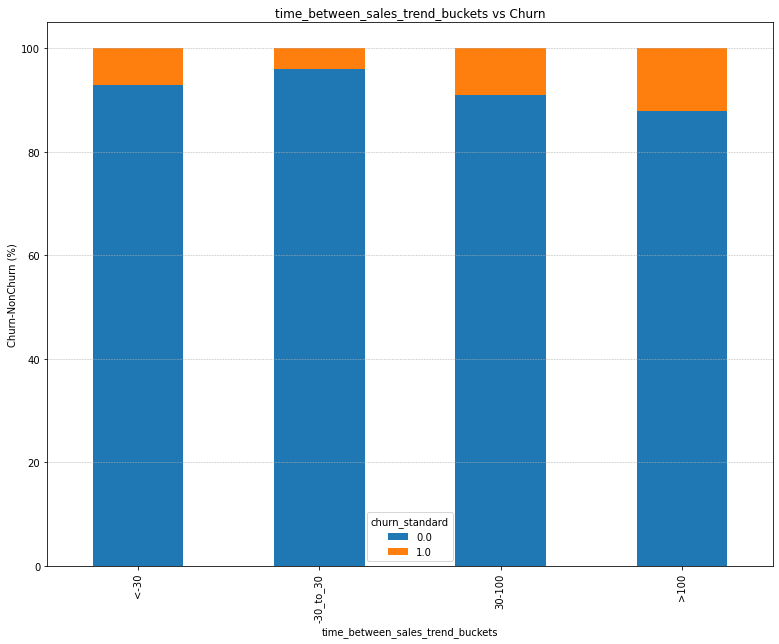

In [32]:
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['time_between_sales_trend'] < -50) ,'time_between_sales_trend_buckets'] = '<-30'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['time_between_sales_trend'] > -50) & (IIT_churn_master_dataset['time_between_sales_trend'] <= 50),'time_between_sales_trend_buckets'] = '-30_to_30'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['time_between_sales_trend'] > 50) & (IIT_churn_master_dataset['time_between_sales_trend'] <= 100),'time_between_sales_trend_buckets'] = '30-100'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['time_between_sales_trend'] > 100),'time_between_sales_trend_buckets'] = '>100'

df_group = IIT_churn_master_dataset.groupby(['time_between_sales_trend_buckets','churn_standard'])['Customer No'].count().reset_index()
df_group['time_between_sales_trend_buckets'] = df_group['time_between_sales_trend_buckets'].astype('category')
df_group['time_between_sales_trend_buckets'] = df_group['time_between_sales_trend_buckets'].cat.reorder_categories(['<-30','-30_to_30','30-100','>100'])
df_group_pivot = df_group.pivot_table('Customer No', ['time_between_sales_trend_buckets'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("time_between_sales_trend_buckets vs Churn")
plt.xlabel("time_between_sales_trend_buckets")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

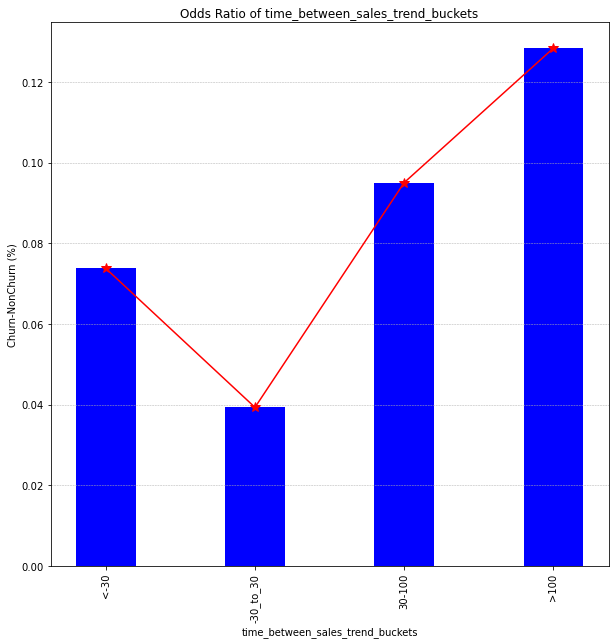

In [1702]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['time_between_sales_trend_buckets'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Odds Ratio of time_between_sales_trend_buckets")
plt.xlabel("time_between_sales_trend_buckets")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")

plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Score: 7

## Perc_DGOP

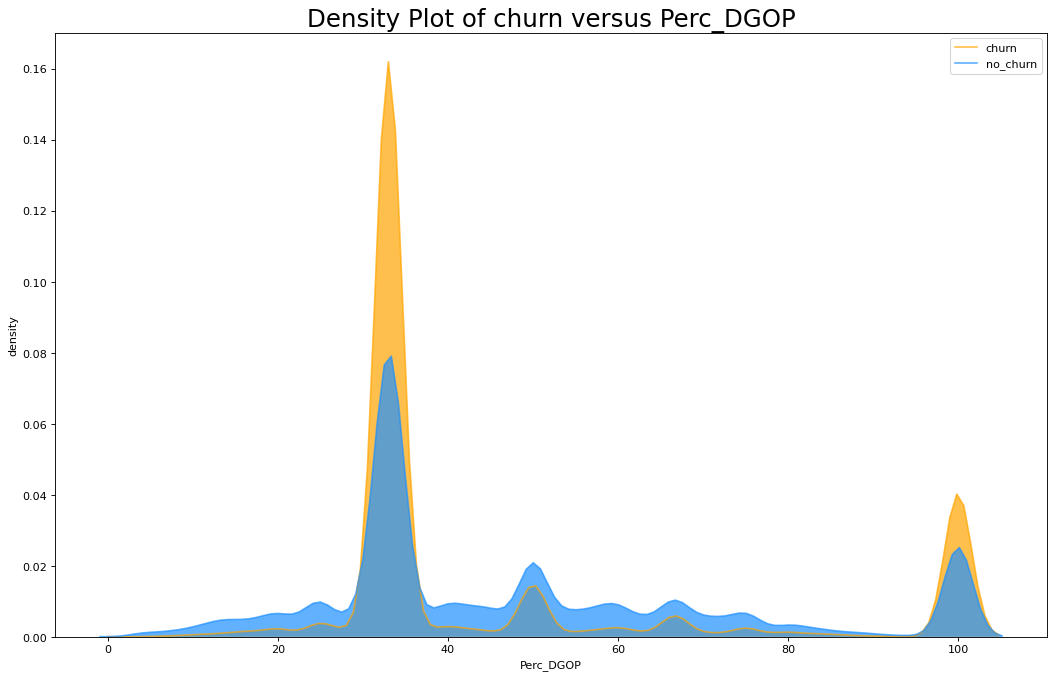

In [33]:
IIT_churn_master_dataset['Perc_DGOP'].fillna(33, inplace = True)
IIT_churn_master_dataset_sub = IIT_churn_master_dataset[['Perc_DGOP','churn_standard']]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 1), "Perc_DGOP"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 0), "Perc_DGOP"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)

# Decoration
plt.title('Density Plot of churn versus Perc_DGOP', fontsize=22)
plt.ylabel('density')
plt.xlabel('Perc_DGOP')
plt.legend()
plt.show()

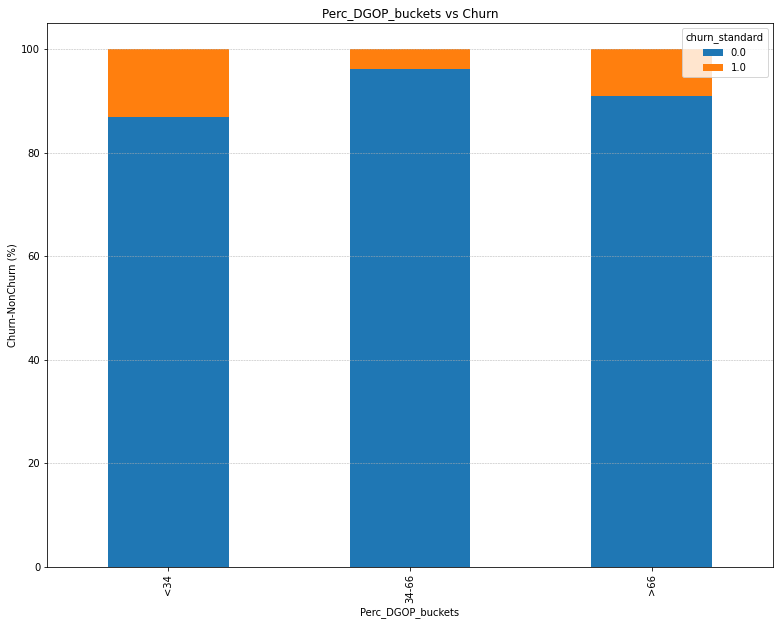

In [34]:
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['Perc_DGOP'] < 34 ),'Perc_DGOP_buckets'] = '<34'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['Perc_DGOP'] > 34) & (IIT_churn_master_dataset['Perc_DGOP'] <= 66),'Perc_DGOP_buckets'] = '34-66'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['Perc_DGOP'] > 66),'Perc_DGOP_buckets'] = '>66'

df_group = IIT_churn_master_dataset.groupby(['Perc_DGOP_buckets','churn_standard'])['Customer No'].count().reset_index()
df_group['Perc_DGOP_buckets'] = df_group['Perc_DGOP_buckets'].astype('category')
df_group['Perc_DGOP_buckets'] = df_group['Perc_DGOP_buckets'].cat.reorder_categories(['<34','34-66','>66'])
df_group_pivot = df_group.pivot_table('Customer No', ['Perc_DGOP_buckets'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("Perc_DGOP_buckets vs Churn")
plt.xlabel("Perc_DGOP_buckets")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

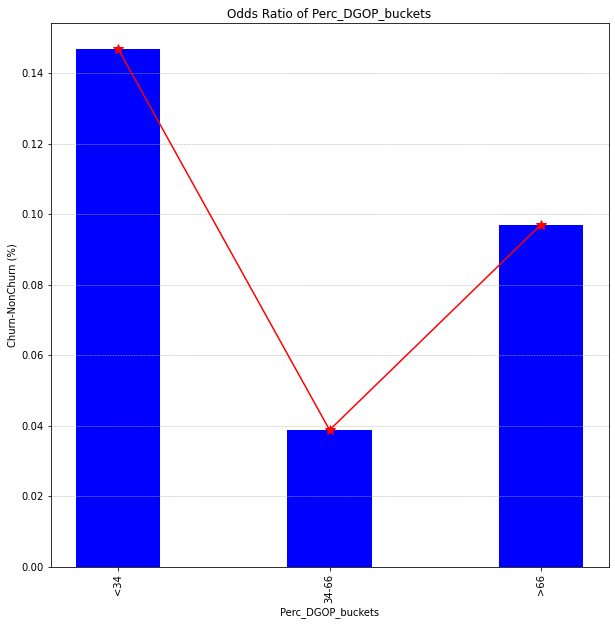

In [1714]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['Perc_DGOP_buckets'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Odds Ratio of Perc_DGOP_buckets")
plt.xlabel("Perc_DGOP_buckets")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")

plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Score: 5

## Dept Diversity Index

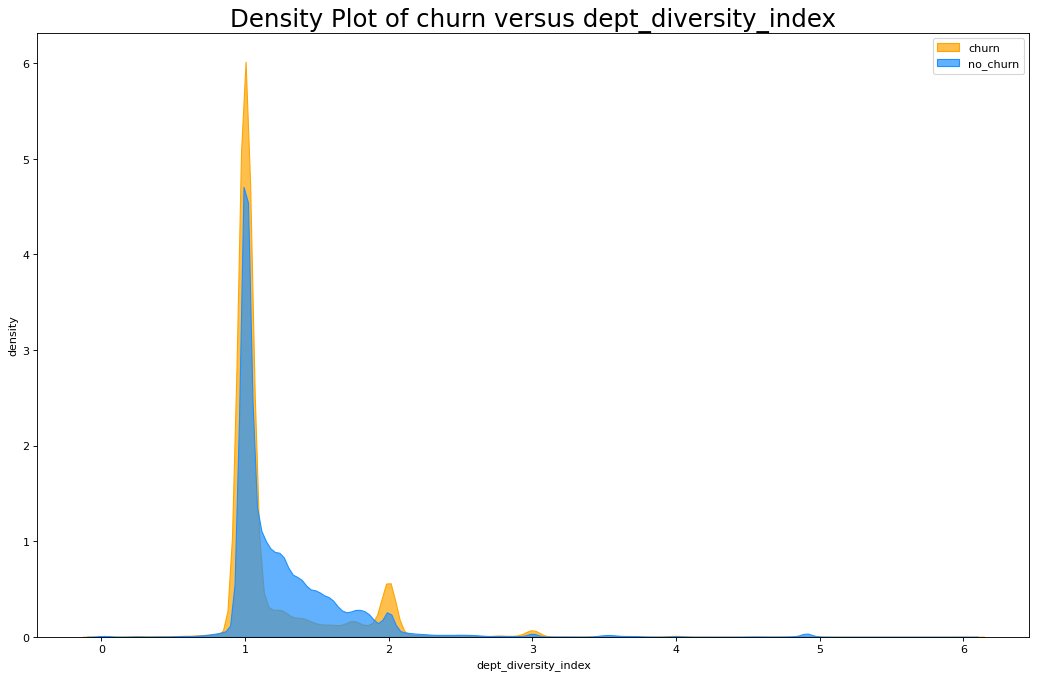

In [1720]:
IIT_churn_master_dataset_sub = IIT_churn_master_dataset[['dept_diversity_index','churn_standard']]
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 1), "dept_diversity_index"], shade=True, color="orange", label="churn", alpha=.7)
sns.kdeplot(IIT_churn_master_dataset_sub.loc[(IIT_churn_master_dataset_sub['churn_standard'] == 0), "dept_diversity_index"], shade=True, color="dodgerblue", label="no_churn", alpha=.7)

# Decoration
plt.title('Density Plot of churn versus dept_diversity_index', fontsize=22)
plt.ylabel('density')
plt.xlabel('dept_diversity_index')
plt.legend()
plt.show()

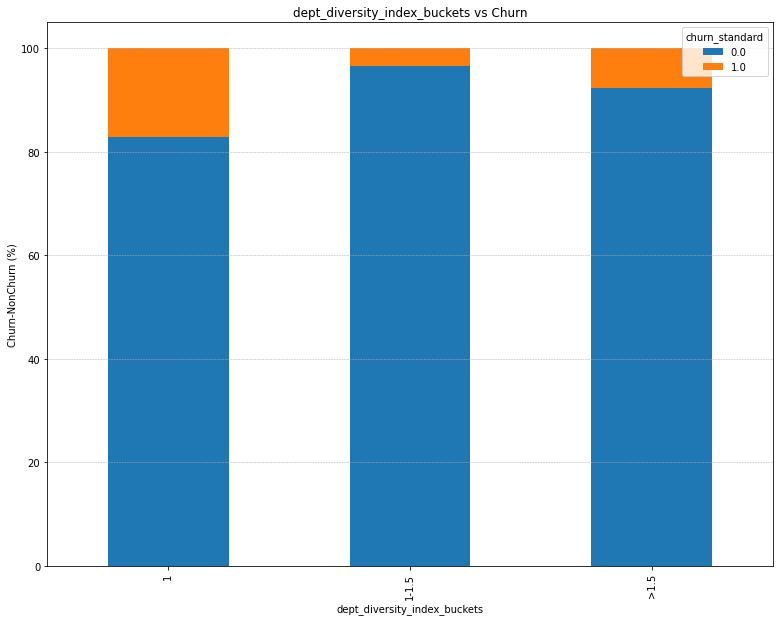

In [35]:
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['dept_diversity_index'] == 1),'dept_diversity_index_buckets'] = '1'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['dept_diversity_index'] > 1) & (IIT_churn_master_dataset['dept_diversity_index'] <= 1.5),'dept_diversity_index_buckets'] = '1-1.5'
IIT_churn_master_dataset.loc[(IIT_churn_master_dataset['dept_diversity_index'] > 1.5) ,'dept_diversity_index_buckets'] = '>1.5'

df_group = IIT_churn_master_dataset.groupby(['dept_diversity_index_buckets','churn_standard'])['Customer No'].count().reset_index()
df_group_pivot = df_group.pivot_table('Customer No', ['dept_diversity_index_buckets'], 'churn_standard')
stacked_data = df_group_pivot.apply(lambda x: x*100/sum(x), axis=1)

stacked_data.plot(kind="bar", stacked=True, figsize = (13, 10))
plt.title("dept_diversity_index_buckets vs Churn")
plt.xlabel("dept_diversity_index_buckets")
plt.ylabel("Churn-NonChurn (%)")
plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)
plt.show()

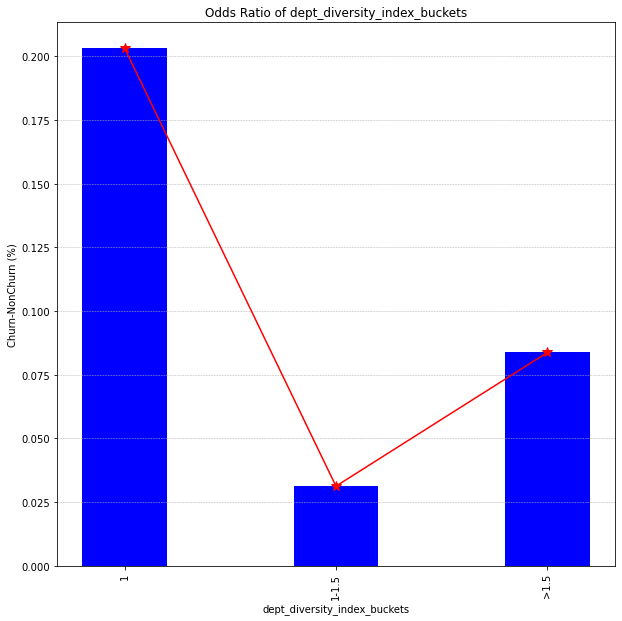

In [1723]:
df_group_pivot['odds_ratio'] = df_group_pivot[1.0]/df_group_pivot[0.0]
df_group_pivot = df_group_pivot.reset_index()
fig = plt.figure(figsize = (10, 10))
plt.bar(df_group_pivot['dept_diversity_index_buckets'], df_group_pivot['odds_ratio'], color ='blue',
        width = 0.4)
df_group_pivot['odds_ratio'].plot(kind='line', marker='*', color='red', ms=10)

plt.title("Odds Ratio of dept_diversity_index_buckets")
plt.xlabel("dept_diversity_index_buckets")
plt.xticks(rotation=90)
plt.ylabel("Churn-NonChurn (%)")

plt.grid(axis = 'y', linestyle = '--', linewidth = 0.5)


Score: 6.5

### Final Dataset preparation

In [36]:
IIT_churn_master_dataset_2 = IIT_churn_master_dataset.drop(['customer_time','Posting Date','time_to_order',
                       'expected_purchase_window','time_to_churn_standard','time_to_churn_modified','churn_modified','churn_score','churn alarm',
                       'HQ_State__c','ZI_Technologies__c','total_platinum_items','total_gold_items',
                       'total_silver_items','total_Bronze_items','total_Metal_items','Platinum_bucket','Customer_specific_pop.Item','BDM_and_Inside_Coverage__c',
                       'ZI_Company_Revenue_Range__c','ZI_Industry__c','Family_Segmentation__c','count_group',
                        'item_diversity_buckets','time_between_sales_trend_buckets','Perc_DGOP_buckets',
                        'dept_diversity_index_buckets','ZI_Company_Ranking__c','ZI_Company_Employee_Range__c',
                         'Total_DGOP_Contacts'],axis = 1)

IIT_churn_master_dataset_2 = IIT_churn_master_dataset_2.rename(columns={"Customer No": "customer_no"})##Imputing Missing Values


In [37]:
##Imputing Missing Values
IIT_churn_master_dataset_2['ZI_Company_Type__c'].fillna('Unknown', inplace = True)
IIT_churn_master_dataset_2['ZI_Number_Of_Locations__c'].fillna(IIT_churn_master_dataset_2['ZI_Number_Of_Locations__c'].mode()[0], inplace = True)
IIT_churn_master_dataset_2['Gradient_Revenue'].fillna(0, inplace = True)
IIT_churn_master_dataset_2['time_between_sales_trend'].fillna(0, inplace = True)
IIT_churn_master_dataset_2['gradient_rev_direction'].fillna('Unknown', inplace = True)
IIT_churn_master_dataset_2['TotalContacts'].fillna(IIT_churn_master_dataset_2['TotalContacts'].mode()[0], inplace = True)
IIT_churn_master_dataset_2['Popular_item_count'].fillna(0, inplace = True)
IIT_churn_master_dataset_2['item_diversity_index'].fillna(0, inplace = True)
IIT_churn_master_dataset_2['Coverage_Priority__c'].fillna('Uncovered', inplace = True)

# Feature Selection

In [38]:
IIT_churn_master_dataset_2['Coverage_Priority__c'] = IIT_churn_master_dataset_2['Coverage_Priority__c'].astype('category')
IIT_churn_master_dataset_2['ZI_Company_Type__c'] = IIT_churn_master_dataset_2['ZI_Company_Type__c'].astype('category')
IIT_churn_master_dataset_2['Platinum_Quality_bucket'] = IIT_churn_master_dataset_2['Platinum_Quality_bucket'].astype('category')
IIT_churn_master_dataset_2['Family_Industry_Description_New__c'] = IIT_churn_master_dataset_2['Family_Industry_Description_New__c'].astype('category')
IIT_churn_master_dataset_2['Territory__c'] = IIT_churn_master_dataset_2['Territory__c'].astype('category')
IIT_churn_master_dataset_2['compliance_score'] = IIT_churn_master_dataset_2['compliance_score'].astype('category')


In [39]:
train = IIT_churn_master_dataset_2[['Coverage_Priority__c', 'ZI_Company_Type__c','count',
       'ZI_Number_Of_Locations__c', 'cumulative_sum_revenue', 
       'Platinum_Gold_Quality_Ratio','tenure', 'AvgCost', 'AvgQuantity','Popular_item_count', 'No.Of Managers',
       'Consolidated_Silverpop', 'TotalContacts', 'Perc_DGOP',
       'Family_Industry_Description_New__c', 'Territory__c',
       'compliance_score', 'Gradient_Revenue', 'time_between_sales_trend',
       'item_diversity_index', 'Client_revenue',
       'plat_gold_per_transaction','customer_no','churn_standard','Tier__c']]

train['last'] = sales_account['last']
IIT_churn_customer_master_dataset_2 = train.loc[(train['last'] == 'true')]

IIT_churn_customer_master_dataset_2=IIT_churn_customer_master_dataset_2.drop(['last'],axis = 1)
train=train.drop(['last'],axis = 1)

<ipython-input-39-7d721a182486>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['last'] = sales_account['last']


In [41]:
train_sub = train[['Coverage_Priority__c', 'ZI_Company_Type__c','count',
       'ZI_Number_Of_Locations__c', 'cumulative_sum_revenue', 
       'Platinum_Gold_Quality_Ratio','tenure', 'AvgCost', 'AvgQuantity','Popular_item_count', 'No.Of Managers',
       'Consolidated_Silverpop', 'TotalContacts', 'Perc_DGOP',
       'Family_Industry_Description_New__c', 'Territory__c',
       'compliance_score', 'Gradient_Revenue', 'time_between_sales_trend',
       'item_diversity_index', 'Client_revenue',
       'plat_gold_per_transaction']]
train_sub = train_sub.apply(preprocessing.LabelEncoder().fit_transform)
ss = StandardScaler()
X_scaled = ss.fit_transform(train_sub)
x = X_scaled
y = IIT_churn_master_dataset_2['churn_standard'].astype('category')


### Random Forest

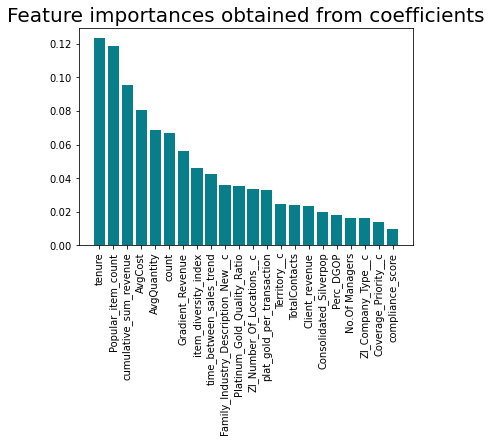

In [47]:
# random forest for feature importance on a classification problem

# define the model
model = RandomForestClassifier()
# fit the model
model = model.fit(X_scaled, y)
# get importance
importances = pd.DataFrame(data={
    'Attribute': train_sub.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Kbest

In [48]:
# Feature Selection with Univariate Statistical Tests
# load data
X = x
Y = y
# feature extraction
test = SelectKBest(score_func=f_classif, k=7)
fit = test.fit(X, Y)
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

[ 4993.069  2892.662  7991.631   803.993 41578.386  1279.829 27067.743
 14007.526 11711.114 18161.178  6089.772  6355.843  9203.399   384.169
   956.249  3397.501  1210.871   465.418   365.707  2160.609  1317.701
  1147.303]
[[-0.452 -1.279 -1.204 -0.367 -0.622 -0.693 -0.51 ]
 [-0.446 -1.505 -1.183 -1.607 -0.938 -0.693 -0.51 ]
 [-0.452 -1.383 -1.204 -1.069 -0.907 -0.631 -0.315]
 [-0.446 -1.332 -1.137 -1.295 -0.907 -0.631 -0.315]
 [-0.44  -1.119 -1.057 -0.943 -0.885 -0.631 -0.315]]


In [49]:
cols = test.get_support(indices=True)
features_df_new = train.iloc[:,cols]
features_df_new

,count,cumulative_sum_revenue,tenure,AvgCost,AvgQuantity,Popular_item_count,TotalContacts
0,1,258.77,0.0,258.770000,9.000000,1.0,1.0
1,2,0.00,13.0,0.000000,0.000000,1.0,1.0
2,1,138.70,0.0,138.700000,3.000000,4.0,6.0
3,2,195.43,42.0,97.715000,3.000000,4.0,6.0
4,3,485.23,93.0,161.743333,3.666667,4.0,6.0
...,...,...,...,...,...,...,...
418275,2,169.56,5.0,84.780000,4.000000,2.0,1.0
418276,1,194.57,0.0,194.570000,7.000000,2.0,1.0
418277,2,258.83,1.0,129.415000,5.500000,2.0,1.0
418278,1,24.78,0.0,24.780000,2.000000,2.0,1.0


### RFE 

In [51]:
# Feature Extraction with RFE
# load data
X = x
Y = y
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select = 7)
fit = rfe.fit(X, Y)

feature_names = np.array(train_sub.columns) # transformed list to array
feature_names[fit.support_]

array(['count', 'cumulative_sum_revenue', 'tenure', 'AvgCost',
       'Popular_item_count', 'No.Of Managers', 'TotalContacts'],
      dtype=object)

# Model Building

In [52]:
Transaction_final_data = train
customer = IIT_churn_customer_master_dataset_2
customer = customer.reset_index(drop=True)

#Transaction_final_data=Transaction_final_data.drop(['Unnamed: 0','Unnamed: 0.1'],axis = 1)
#customer=customer.drop(['Unnamed: 0.1','Unnamed: 0'],axis = 1)
#output_data.drop('Unnamed: 0',axis = 1, inplace = True)
output_data = output_data.rename(columns={"Customer No": "customer_no"})

## Pre-Processing Transaction Data

In [53]:
df3 = Transaction_final_data[['Coverage_Priority__c', 'ZI_Company_Type__c', 'Family_Industry_Description_New__c',
       'Territory__c', 'Client_revenue','compliance_score']].copy()

one_hot_encoded_data = pd.get_dummies(df3)

df2 = Transaction_final_data[['count', 'ZI_Number_Of_Locations__c', 'cumulative_sum_revenue',
       'Platinum_Gold_Quality_Ratio', 'tenure','AvgCost','AvgQuantity','Popular_item_count',
        'Perc_DGOP','Gradient_Revenue','time_between_sales_trend',
        'item_diversity_index','plat_gold_per_transaction','customer_no']].copy()

tiers_exclude = ['GOV','','DISTST','GOVCON']

In [54]:
ss = StandardScaler()
x_scaled= pd.DataFrame(ss.fit_transform(df2.drop('customer_no', axis=1)))
x_scaled.columns = df2.drop('customer_no', axis=1).columns
x_transaction = pd.concat([x_scaled, one_hot_encoded_data, Transaction_final_data['customer_no'],Transaction_final_data['churn_standard'],Transaction_final_data['Tier__c']], axis=1)
x_transaction = x_transaction[~x_transaction.Tier__c.isin(tiers_exclude)]
x_transaction = x_transaction.drop('Tier__c', axis=1)
y_transaction = x_transaction['churn_standard']

## Pre-Processing Customer Data

In [55]:
df1 = customer[['Coverage_Priority__c', 'ZI_Company_Type__c', 'Family_Industry_Description_New__c',
       'Territory__c', 'Client_revenue','compliance_score']].copy()

one_hot_encoded_data_c = pd.get_dummies(df1)

df4 = customer[['count', 'ZI_Number_Of_Locations__c', 'cumulative_sum_revenue',
       'Platinum_Gold_Quality_Ratio', 'tenure','AvgCost','AvgQuantity','Popular_item_count',
        'Perc_DGOP','Gradient_Revenue','time_between_sales_trend',
        'item_diversity_index','plat_gold_per_transaction','customer_no']].copy()

In [56]:
x_scaled_c= pd.DataFrame(ss.fit_transform(df4.drop('customer_no', axis=1)))
x_scaled_c.columns = df4.drop('customer_no', axis=1).columns
x_transaction_c = pd.concat([x_scaled_c, one_hot_encoded_data_c, customer['Tier__c'],customer['customer_no'],customer['churn_standard']], axis=1)
x_transaction_c = x_transaction_c[~x_transaction_c.Tier__c.isin(tiers_exclude)]
x_transaction_c = x_transaction_c.drop('Tier__c', axis=1)
y_transaction_c = x_transaction_c['churn_standard']
x_transaction_c = x_transaction_c


In [ ]:
# Renaming Columns
x_transaction_c_1 = x_transaction_c.rename(columns={"count":"Count_Of_Transactions","ZI_Number_Of_Locations__c":"Number_of_Locations","cumulative_sum_revenue":"Cumulative_Sum_Of_Revenue","tenure":"Customer_Tenure","AvgCost":"Average_Cost_Of_Transactions","AvgQuantity":"Average_Quantity_Of_Items","Popular_item_count":"Count_Of_Popular_Items","Consolidated_Silverpop":"Consolidated_Customer_Silver_Pop_Score","Perc_DGOP":"Percentage_Of_DG_OP_Contacts","Gradient_Revenue":"Change_In_Revenue","time_between_sales_trend":"Duration_Between_Transactions","item_diversity_index":"Index_for_Item_Diversity","plat_gold_per_transaction":"Platinum_and_Gold_Items_per_Transactions","Coverage_Priority__c_Amazon":"Coverage_Priority_for_Amazon","Coverage_Priority__c_BDM":"Coverage_Priority_for_BDM","Coverage_Priority__c_Distributor":"Coverage_Priority_for_Distributor",'Coverage_Priority__c_Government':'Coverage_Priority_for_Government','Coverage_Priority__c_Government Contractor':'Coverage_Priority_for_Government_Contractor','Coverage_Priority__c_Inside Sales':'Coverage_Priority_for_Inside_Sales','Coverage_Priority__c_Internal Customer':'Coverage_Priority_for_Internal_Customer','Coverage_Priority__c_Spacemaster':'Coverage_Priority_for_Spacemaster','Coverage_Priority__c_Strategic Distributor':'Coverage_Priority_for_Strategic_Distributor','Coverage_Priority__c_Uncovered':'Coverage_Priority_for_Uncovered','ZI_Company_Type__c_EDUCATION':'Company_Type_as_EDUCATION','ZI_Company_Type__c_GOVERNMENT':'Company_Type_as_GOVERNMENT','ZI_Company_Type__c_NPO':'Company_Type_as_NPO','ZI_Company_Type__c_OTHER':'Company_Type_as_OTHER','ZI_Company_Type__c_PRIVATE':'Company_Type_as_PRIVATE','ZI_Company_Type__c_PUBLIC':'Company_Type_as_PUBLIC','ZI_Company_Type__c_Private':'Company_Type_as_Private','ZI_Company_Type__c_Unknown':'Company_Type_as_UNKNOWN','Family_Industry_Description_New__c_Agriculture & Food':'Family_Industry_as_Agriculture_&_Food','Family_Industry_Description_New__c_Automotive':'Family_Industry_as_Automotive','Family_Industry_Description_New__c_Aviation & Aerospace':'Family_Industry_as_Aviation_&_Aerospace','Family_Industry_Description_New__c_Chemical':'Family_Industry_as_Chemical','Family_Industry_Description_New__c_Education':'Family_Industry_as_Education','Family_Industry_Description_New__c_Gov & Military':'Family_Industry_as_Govt_&_Military','Family_Industry_Description_New__c_Mining Oil & Gas':'Family_Industry_as_MiningOil_&_Gas','Family_Industry_Description_New__c_Other':'Family_Industry_as_Other','Family_Industry_Description_New__c_Other Manufacturing':'Family_Industry_as_Other_Manufacturing','Family_Industry_Description_New__c_Pharma & Healthcare':'Family_Industry_as_Pharma_&_Healthcare','Family_Industry_Description_New__c_Retail Trade':'Family_Industry_as_Retail_Trade','Family_Industry_Description_New__c_Services':'Family_Industry_as_Services','Family_Industry_Description_New__c_Technology':'Family_Industry_as_Technology','Family_Industry_Description_New__c_Transport & Warehouse':'Family_Industry_as_Transport_&_Warehouse','Family_Industry_Description_New__c_Transport Equipment':'Family_Industry_as_Transport_Equipment','Family_Industry_Description_New__c_Unassigned':'Family_Industry_as_Unassigned','Family_Industry_Description_New__c_WasteManagement':'Family_Industry_as_Waste_Management','Family_Industry_Description_New__c_Wholesale Trade':'Family_Industry_as_Wholesale_Trade','Territory__c_CANADA':'Territory_CANADA','Territory__c_GREAT LAKES':'Territory_GREAT_LAKES','Territory__c_MIDWEST':'Territory_MIDWEST','Territory__c_Mid-Atlantic':'Territory_MID_ATLANTIC','Territory__c_NORTHEAST':'Territory_NORTHEAST', 'Territory__c_SOUTHEAST':'Territory_SOUTHEAST','Territory__c_UNKNOWN':'Territory_UNKNOWN','Territory__c_WEST':'Territory_WEST','Client_revenue_$100mil-$500mil':'Client_Revenue_Range_$100mil-$500mil','Client_revenue_$10mil-$100mil':'Client_Revenue_Range_$10mil-$100mil','Client_revenue_$1mil-$10mil':'Client_Revenue_Range_$1mil-$10mil','Client_revenue_$500mil-$5bil':'Client_Revenue_Range_$500mil-$5bil','Client_revenue_Over $5bil':'Client_Revenue_Range_Over_$5bil','Client_revenue_Under$1mil':'Client_Revenue_Range_Under$1mil','Client_revenue_other':'Client_Revenue_Range_Other','compliance_score_High':'Compliance_Score_as_High', 'compliance_score_Low':'Compliance_Score_as_Low','compliance_score_Medium':'Compliance_Score_as_Medium'})


## Train-Test Split

In [57]:
X_train, X_test, y_train, y_test = train_test_split(x_transaction_c,y_transaction_c, test_size=0.1,random_state=10, stratify=y_transaction_c)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.222, random_state=11, stratify=y_train)
# Creating training set from transaction wise data
X_train_transaction = x_transaction[x_transaction['customer_no'].isin(X_train['customer_no'])]
y_train_transaction = X_train_transaction['churn_standard']

X_train = X_train.dropna()
X_val = X_val.dropna()
X_test = X_test.dropna()
y_train = X_train['churn_standard']
y_val = X_val['churn_standard']
y_test = X_test['churn_standard']

X_train_transaction.drop(['churn_standard'], axis=1, inplace=True)
X_train.drop(['churn_standard'], axis=1, inplace=True)
X_val.drop(['churn_standard'], axis=1, inplace=True)
X_test.drop(['churn_standard'], axis=1, inplace=True)

<ipython-input-57-2e6c2f3e9b7a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_transaction.drop(['churn_standard'], axis=1, inplace=True)


## XGBoost


### Training

In [58]:
# Implementing XGBoosting and Gradient boosting with hyperparameter tuning
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=6 , use_label_encoder =False,
    eval_metric='logloss',
    learning_rate = 0.1,
    gamma = 0.9
)

X_train_c = X_train.loc[:, X_train.columns != 'customer_no']
X_val_c = X_val.loc[:, X_val.columns != 'customer_no']
X_test_c = X_test.loc[:, X_test.columns != 'customer_no']
clf = estimator.fit(X_train_c, y_train)

C:\Users\92306\anaconda3\lib\site-packages\xgboost\data.py:200: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Validation Data

F1Score XBoost: 89.04974993419323
Accuracy XBoost: 87.45287286985372
Recall XBoost: 93.9200444197668


C:\Users\92306\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


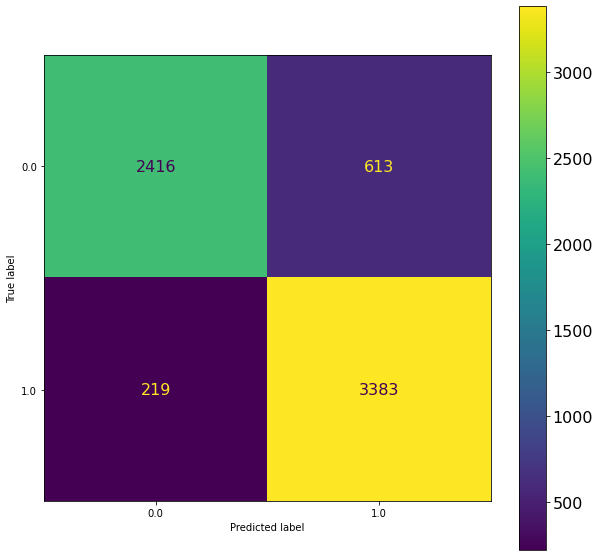

In [59]:

y_pred = clf.predict(X_val_c)
print("F1Score XBoost:",metrics.f1_score(y_val, y_pred)*100)
print("Accuracy XBoost:",metrics.accuracy_score(y_val, y_pred)*100)
print("Recall XBoost:",metrics.recall_score(y_val, y_pred)*100)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(clf, X_val_c, y_val,ax=ax)  
plt.show()

In [60]:
target_names = ['0', '1']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.92      0.80      0.85      3029
           1       0.85      0.94      0.89      3602

    accuracy                           0.87      6631
   macro avg       0.88      0.87      0.87      6631
weighted avg       0.88      0.87      0.87      6631



#### Threshold optimization

In [61]:
#Threshold optimization
yhat_xg = clf.predict_proba(X_val_c)
probs_xg = yhat_xg[:, 1]
thresholds = np.arange(0, 1, 0.001)

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

scores = [metrics.f1_score(y_val, to_labels(probs_xg, t)) for t in thresholds]
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

threshold = thresholds[ix]
y_pred_thresh = ((clf.predict_proba(X_val_c)[:, 1])>= threshold).astype(int)
metrics.confusion_matrix(y_val, y_pred_thresh, labels = [0, 1])

Threshold=0.451, F-Score=0.89382


array([[2370,  659],
       [ 159, 3443]], dtype=int64)

#### ROC AUC 

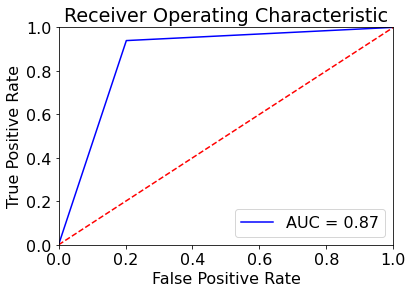

In [62]:
fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Test Data

F1Score XBoost: 89.50939457202506
Accuracy XBoost: 87.8879180476047


C:\Users\92306\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


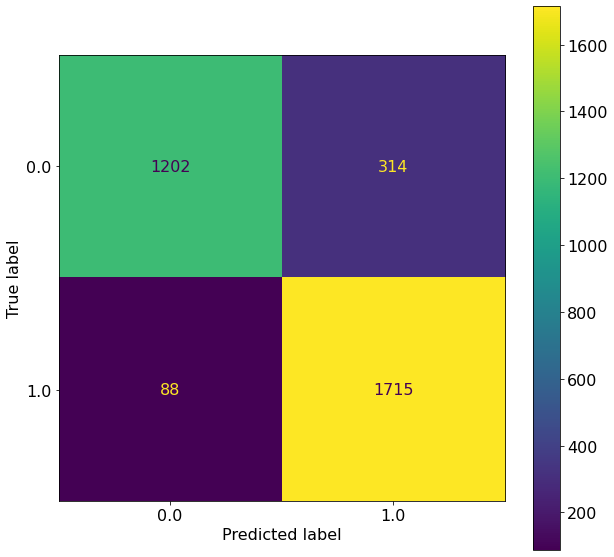

In [63]:
y_pred = clf.predict(X_test_c)
print("F1Score XBoost:",metrics.f1_score(y_test, y_pred)*100)
print("Accuracy XBoost:",metrics.accuracy_score(y_test, y_pred)*100)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(clf, X_test_c, y_test,ax=ax)  
plt.show()

In [64]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1516
           1       0.85      0.95      0.90      1803

    accuracy                           0.88      3319
   macro avg       0.89      0.87      0.88      3319
weighted avg       0.88      0.88      0.88      3319



In [65]:
yhat = clf.predict_proba(X_train_c)
probs_train = yhat[:, 1]
X_train['churn_probability_XGBoost'] = probs_train
#X_train_xg = X_train[['customer_no','churn_probability_XGBoost']]

yhat = clf.predict_proba(X_val_c)
probs_val = yhat[:, 1]
X_val['churn_probability_XGBoost'] = probs_val
#X_val_xg = X_val[['customer_no','churn_probability_XGBoost']]

yhat = clf.predict_proba(X_test_c)
probs_test = yhat[:, 1]
X_test['churn_probability_XGBoost'] = probs_test
#X_test_xg = X_test[['customer_no','churn_probability_XGBoost']]

X_train_xg = X_train[['customer_no','churn_probability_XGBoost']]
X_val_xg = X_val[['customer_no','churn_probability_XGBoost']]
X_test_xg = X_test[['customer_no','churn_probability_XGBoost']]
xg_results = pd.concat([X_train_xg,X_val_xg,X_test_xg])

C:\Users\92306\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\92306\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Gain & Lift

In [66]:
# Getting probability on the test dataset
y_test_prob = clf.predict_proba(X_test_c)
probability_df = pd.DataFrame({'Actual_op':y_test,'pred_op':y_pred}).reset_index(drop=True)
probability_df = pd.concat([probability_df, pd.DataFrame(y_test_prob)], axis=1).reset_index(drop=True)
probability_df.rename({0:'0_probability',1:'1_probability'}, axis=1, inplace=True)

# Sorting probability of getting 1 in decending order 
probability_df.sort_values('1_probability', ascending=False, inplace=True)
probability_df=probability_df.reset_index(drop=True)

C:\Users\92306\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [67]:
# Creating 10 Deciles
decile_1 = probability_df[probability_df.index<=332]
decile_2 = probability_df[(332<probability_df.index) & (probability_df.index<=2*332)]
decile_3 = probability_df[(2*332<probability_df.index) & (probability_df.index<=3*332)]
decile_4 = probability_df[(3*332<probability_df.index) & (probability_df.index<=4*332)]
decile_5 = probability_df[(4*332<probability_df.index) & (probability_df.index<=5*332)]
decile_6 = probability_df[(5*332<probability_df.index) & (probability_df.index<=6*332)]
decile_7 = probability_df[(6*332<probability_df.index) & (probability_df.index<=7*332)]
decile_8 = probability_df[(7*332<probability_df.index) & (probability_df.index<=8*332)]
decile_9 = probability_df[(8*332<probability_df.index) & (probability_df.index<=9*332)]
decile_10 = probability_df[9*332<probability_df.index]

In [68]:
gl_matrix = pd.DataFrame({'Decile':[1,2,3,4,5,6,7,8,9,10],
                         'Number_of_samples':[333,332,332,332,332,332,332,332,332,332],
                         'Actual_churn':[333,328,306,290,233,181,86,1,0,0]})
gl_matrix['cumulative_churn'] = gl_matrix['Actual_churn'].cumsum()
gl_matrix['%_of_churn'] = (gl_matrix['Actual_churn']/1758)*100
gl_matrix['Gain'] = gl_matrix['%_of_churn'].cumsum()
gl_matrix['Lift'] = gl_matrix['Gain']/(gl_matrix['Decile']*10)
gl_matrix['Response'] = (gl_matrix['Actual_churn']/gl_matrix['Number_of_samples'])*100

gl_matrix

,Decile,Number_of_samples,Actual_churn,cumulative_churn,%_of_churn,Gain,Lift,Response
0,1,333,333,333,18.941980,18.941980,1.894198,100.000000
1,2,332,328,661,18.657565,37.599545,1.879977,98.795181
2,3,332,306,967,17.406143,55.005688,1.833523,92.168675
3,4,332,290,1257,16.496018,71.501706,1.787543,87.349398
4,5,332,233,1490,13.253697,84.755404,1.695108,70.180723
5,6,332,181,1671,10.295791,95.051195,1.584187,54.518072
6,7,332,86,1757,4.891923,99.943117,1.427759,25.903614
7,8,332,1,1758,0.056883,100.000000,1.250000,0.301205
8,9,332,0,1758,0.000000,100.000000,1.111111,0.000000
9,10,332,0,1758,0.000000,100.000000,1.000000,0.000000


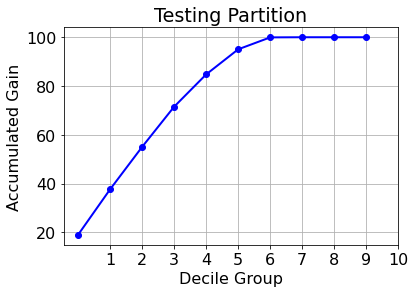

In [69]:
plt.plot(gl_matrix.index, gl_matrix['Gain'], marker = 'o',
         color = 'blue', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.title("Testing Partition")
plt.grid(True)
plt.xticks(np.arange(1,11, 1))
plt.xlabel("Decile Group")
plt.ylabel("Accumulated Gain")
plt.show()

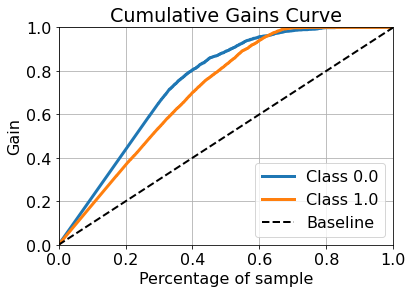

In [70]:
skplt.metrics.plot_cumulative_gain(y_test, y_test_prob)

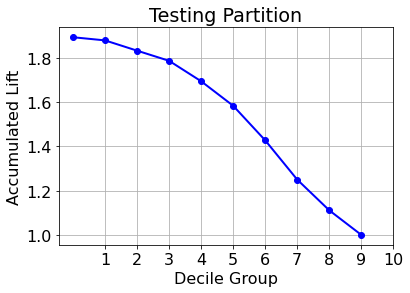

In [71]:
plt.plot(gl_matrix.index, gl_matrix['Lift'], marker = 'o',
         color = 'blue', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.title("Testing Partition")
plt.grid(True)
plt.xticks(np.arange(1,11, 1))
plt.xlabel("Decile Group")
plt.ylabel("Accumulated Lift")
plt.show()

## Logistic Regression

### Training

In [76]:
x_transaction_c_1 = x_transaction_c.rename(columns={"count":"Count_Of_Transactions","ZI_Number_Of_Locations__c":"Number_of_Locations","cumulative_sum_revenue":"Cumulative_Sum_Of_Revenue","tenure":"Customer_Tenure","AvgCost":"Average_Cost_Of_Transactions","AvgQuantity":"Average_Quantity_Of_Items","Popular_item_count":"Count_Of_Popular_Items","Consolidated_Silverpop":"Consolidated_Customer_Silver_Pop_Score","Perc_DGOP":"Percentage_Of_DG_OP_Contacts","Gradient_Revenue":"Change_In_Revenue","time_between_sales_trend":"Duration_Between_Transactions","item_diversity_index":"Index_for_Item_Diversity","plat_gold_per_transaction":"Platinum_and_Gold_Items_per_Transactions","Coverage_Priority__c_Amazon":"Coverage_Priority_for_Amazon","Coverage_Priority__c_BDM":"Coverage_Priority_for_BDM","Coverage_Priority__c_Distributor":"Coverage_Priority_for_Distributor",'Coverage_Priority__c_Government':'Coverage_Priority_for_Government','Coverage_Priority__c_Government Contractor':'Coverage_Priority_for_Government_Contractor','Coverage_Priority__c_Inside Sales':'Coverage_Priority_for_Inside_Sales','Coverage_Priority__c_Internal Customer':'Coverage_Priority_for_Internal_Customer','Coverage_Priority__c_Spacemaster':'Coverage_Priority_for_Spacemaster','Coverage_Priority__c_Strategic Distributor':'Coverage_Priority_for_Strategic_Distributor','Coverage_Priority__c_Uncovered':'Coverage_Priority_for_Uncovered','ZI_Company_Type__c_EDUCATION':'Company_Type_as_EDUCATION','ZI_Company_Type__c_GOVERNMENT':'Company_Type_as_GOVERNMENT','ZI_Company_Type__c_NPO':'Company_Type_as_NPO','ZI_Company_Type__c_OTHER':'Company_Type_as_OTHER','ZI_Company_Type__c_PRIVATE':'Company_Type_as_PRIVATE','ZI_Company_Type__c_PUBLIC':'Company_Type_as_PUBLIC','ZI_Company_Type__c_Private':'Company_Type_as_Private','ZI_Company_Type__c_Unknown':'Company_Type_as_UNKNOWN','Family_Industry_Description_New__c_Agriculture & Food':'Family_Industry_as_Agriculture_&_Food','Family_Industry_Description_New__c_Automotive':'Family_Industry_as_Automotive','Family_Industry_Description_New__c_Aviation & Aerospace':'Family_Industry_as_Aviation_&_Aerospace','Family_Industry_Description_New__c_Chemical':'Family_Industry_as_Chemical','Family_Industry_Description_New__c_Education':'Family_Industry_as_Education','Family_Industry_Description_New__c_Gov & Military':'Family_Industry_as_Govt_&_Military','Family_Industry_Description_New__c_Mining Oil & Gas':'Family_Industry_as_MiningOil_&_Gas','Family_Industry_Description_New__c_Other':'Family_Industry_as_Other','Family_Industry_Description_New__c_Other Manufacturing':'Family_Industry_as_Other_Manufacturing','Family_Industry_Description_New__c_Pharma & Healthcare':'Family_Industry_as_Pharma_&_Healthcare','Family_Industry_Description_New__c_Retail Trade':'Family_Industry_as_Retail_Trade','Family_Industry_Description_New__c_Services':'Family_Industry_as_Services','Family_Industry_Description_New__c_Technology':'Family_Industry_as_Technology','Family_Industry_Description_New__c_Transport & Warehouse':'Family_Industry_as_Transport_&_Warehouse','Family_Industry_Description_New__c_Transport Equipment':'Family_Industry_as_Transport_Equipment','Family_Industry_Description_New__c_Unassigned':'Family_Industry_as_Unassigned','Family_Industry_Description_New__c_WasteManagement':'Family_Industry_as_Waste_Management','Family_Industry_Description_New__c_Wholesale Trade':'Family_Industry_as_Wholesale_Trade','Territory__c_CANADA':'Territory_CANADA','Territory__c_GREAT LAKES':'Territory_GREAT_LAKES','Territory__c_MIDWEST':'Territory_MIDWEST','Territory__c_Mid-Atlantic':'Territory_MID_ATLANTIC','Territory__c_NORTHEAST':'Territory_NORTHEAST', 'Territory__c_SOUTHEAST':'Territory_SOUTHEAST','Territory__c_UNKNOWN':'Territory_UNKNOWN','Territory__c_WEST':'Territory_WEST','Client_revenue_$100mil-$500mil':'Client_Revenue_Range_$100mil-$500mil','Client_revenue_$10mil-$100mil':'Client_Revenue_Range_$10mil-$100mil','Client_revenue_$1mil-$10mil':'Client_Revenue_Range_$1mil-$10mil','Client_revenue_$500mil-$5bil':'Client_Revenue_Range_$500mil-$5bil','Client_revenue_Over $5bil':'Client_Revenue_Range_Over_$5bil','Client_revenue_Under$1mil':'Client_Revenue_Range_Under$1mil','Client_revenue_other':'Client_Revenue_Range_Other','compliance_score_High':'Compliance_Score_as_High', 'compliance_score_Low':'Compliance_Score_as_Low','compliance_score_Medium':'Compliance_Score_as_Medium'})
X_train, X_test, y_train, y_test = train_test_split(x_transaction_c_1,y_transaction_c, test_size=0.1,random_state=10, stratify=y_transaction_c)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.222, random_state=11, stratify=y_train)
# Creating training set from transaction wise data
X_train_transaction = x_transaction[x_transaction['customer_no'].isin(X_train['customer_no'])]
y_train_transaction = X_train_transaction['churn_standard']

X_train = X_train.dropna()
X_val = X_val.dropna()
X_test = X_test.dropna()
y_train = X_train['churn_standard']
y_val = X_val['churn_standard']
y_test = X_test['churn_standard']

X_train_transaction.drop(['churn_standard'], axis=1, inplace=True)
X_train.drop(['churn_standard'], axis=1, inplace=True)
X_val.drop(['churn_standard'], axis=1, inplace=True)
X_test.drop(['churn_standard'], axis=1, inplace=True)

<ipython-input-76-368227918aea>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_transaction.drop(['churn_standard'], axis=1, inplace=True)


In [77]:
X_train_na = X_train.dropna()
X_val_na = X_val.dropna()
X_test_na = X_test.dropna()

X_train_sub = X_train_na[['Count_Of_Transactions','Customer_Tenure','Cumulative_Sum_Of_Revenue','Platinum_Gold_Quality_Ratio','Count_Of_Popular_Items',
                      'Change_In_Revenue','Duration_Between_Transactions','Index_for_Item_Diversity'
                       ,'Coverage_Priority_for_Uncovered','customer_no']]

X_val_sub = X_val_na[['Count_Of_Transactions','Customer_Tenure','Cumulative_Sum_Of_Revenue','Platinum_Gold_Quality_Ratio','Count_Of_Popular_Items',
                      'Change_In_Revenue','Duration_Between_Transactions','Index_for_Item_Diversity'
                       ,'Coverage_Priority_for_Uncovered','customer_no']]

X_test_sub = X_test_na[['Count_Of_Transactions','Customer_Tenure','Cumulative_Sum_Of_Revenue','Platinum_Gold_Quality_Ratio','Count_Of_Popular_Items',
                      'Change_In_Revenue','Duration_Between_Transactions','Index_for_Item_Diversity'
                       ,'Coverage_Priority_for_Uncovered','customer_no']]

X_train_c = X_train_sub.loc[:, X_train_sub.columns != 'customer_no']
X_val_c = X_val_sub.loc[:, X_val_sub.columns != 'customer_no']
X_test_c = X_test_sub.loc[:, X_test_sub.columns != 'customer_no']

logit = LogisticRegression( penalty = 'l2',max_iter = 500)
logit = logit.fit(X_train_c, y_train)

### Validation Data

F1Score XBoost: 81.09618198749502
Accuracy XBoost: 78.57035137988237


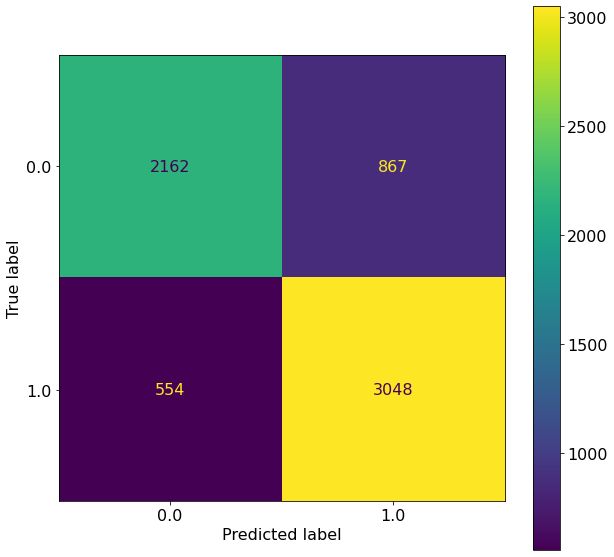

In [78]:
y_pred = logit.predict(X_val_c)
print("F1Score XBoost:",metrics.f1_score(y_val, y_pred)*100)
print("Accuracy XBoost:",metrics.accuracy_score(y_val, y_pred)*100)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(logit, X_val_c, y_val,ax=ax)  
plt.show()

In [79]:
target_names = ['0', '1']
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      3029
           1       0.78      0.85      0.81      3602

    accuracy                           0.79      6631
   macro avg       0.79      0.78      0.78      6631
weighted avg       0.79      0.79      0.78      6631



#### ROC AUC 

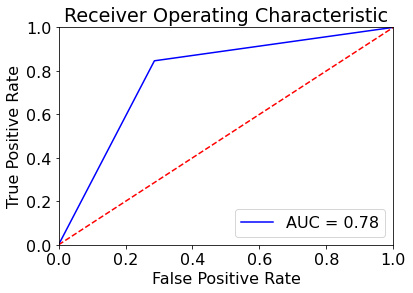

In [80]:
fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Threshold optimization

In [81]:
yhat = logit.predict_proba(X_val_c)
probs = yhat[:, 1]
thresholds = np.arange(0, 1, 0.001)
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

scores = [metrics.f1_score(y_val, to_labels(probs, t)) for t in thresholds]
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
threshold = thresholds[ix]
y_pred_thresh = ((logit.predict_proba(X_val_c)[:, 1])>= threshold).astype(int)

Threshold=0.402, F-Score=0.81424


### Test Data

F1Score XBoost: 81.5396302861484
Accuracy XBoost: 78.03555287737271


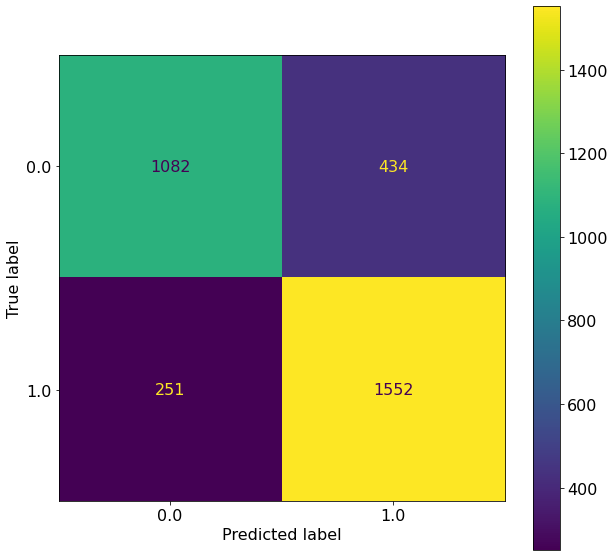

In [82]:
#y_pred = logit.predict(X_test_c)
y_pred_test = ((logit.predict_proba(X_test_c)[:, 1])>= threshold).astype(int)
print("F1Score XBoost:",metrics.f1_score(y_test, y_pred_test)*100)
print("Accuracy XBoost:",metrics.accuracy_score(y_test, y_pred_test)*100)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(logit, X_test_c, y_test,ax=ax)  
plt.show()

In [83]:
target_names = ['0', '1']
print(classification_report(y_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

           0       0.84      0.65      0.73      1516
           1       0.75      0.89      0.82      1803

    accuracy                           0.78      3319
   macro avg       0.79      0.77      0.77      3319
weighted avg       0.79      0.78      0.78      3319



### Feature Importance Logistic

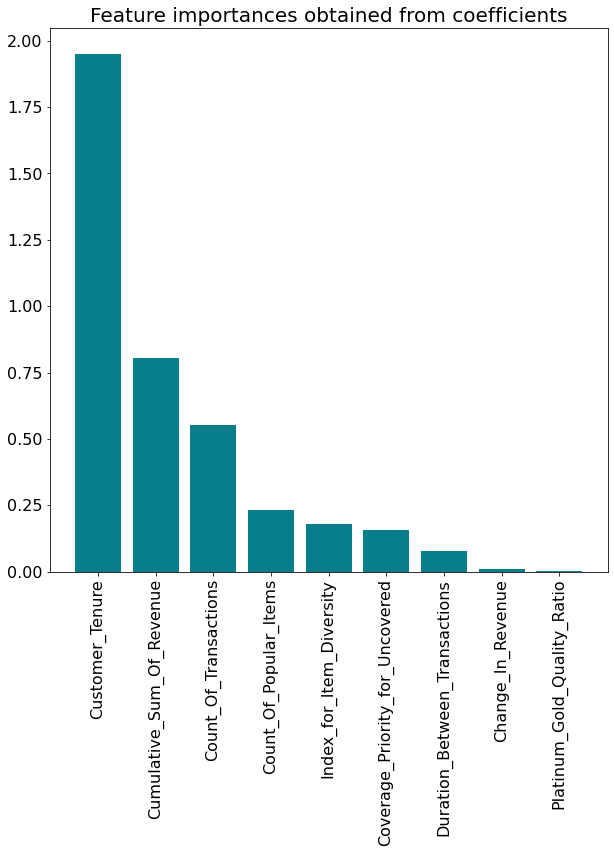

In [84]:
model_1_features = X_train_c.columns.values.tolist()
logit_coef = logit.coef_[0]


importances = pd.DataFrame(data={
    'Attribute': X_train_c.columns,
    'Importance': abs(logit.coef_[0])
})
importances = importances.sort_values(by='Importance', ascending=False)

fig = plt.figure(figsize = (10, 10))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [87]:
cov_contribution = abs(X_train_c.values*logit_coef)
cov_contribution = pd.DataFrame(cov_contribution, columns = X_train_c.columns)
cov_contribution.drop(['Change_In_Revenue','Platinum_Gold_Quality_Ratio'], axis=1, inplace=True)
res =cov_contribution.div(cov_contribution.sum(axis=1), axis=0)
res = res.mul(100)

### Feature Importance Comparison


In [89]:
# Combining test and train set
feature_data = pd.concat([X_train_sub,X_test_sub],axis=0).reset_index(drop=True)
feature_data.dropna(inplace=True)
feature_data_op=pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
feature_data = pd.concat([feature_data,feature_data_op], axis=1).reset_index(drop=True)
churn_mean=feature_data[feature_data['churn_standard']==1].drop(['customer_no','churn_standard'], axis=1).mean()
non_churn_mean=feature_data[feature_data['churn_standard']==0].drop(['customer_no','churn_standard'], axis=1).mean()
customer = customer.rename(columns={"count":"Count_Of_Transactions","ZI_Number_Of_Locations__c":"Number_of_Locations","cumulative_sum_revenue":"Cumulative_Sum_Of_Revenue","tenure":"Customer_Tenure","AvgCost":"Average_Cost_Of_Transactions","AvgQuantity":"Average_Quantity_Of_Items","Popular_item_count":"Count_Of_Popular_Items","Consolidated_Silverpop":"Consolidated_Customer_Silver_Pop_Score","Perc_DGOP":"Percentage_Of_DG_OP_Contacts","Gradient_Revenue":"Change_In_Revenue","time_between_sales_trend":"Duration_Between_Transactions","item_diversity_index":"Index_for_Item_Diversity","plat_gold_per_transaction":"Platinum_and_Gold_Items_per_Transactions","Coverage_Priority__c_Amazon":"Coverage_Priority_for_Amazon","Coverage_Priority__c_BDM":"Coverage_Priority_for_BDM","Coverage_Priority__c_Distributor":"Coverage_Priority_for_Distributor",'Coverage_Priority__c_Government':'Coverage_Priority_for_Government','Coverage_Priority__c_Government Contractor':'Coverage_Priority_for_Government_Contractor','Coverage_Priority__c_Inside Sales':'Coverage_Priority_for_Inside_Sales','Coverage_Priority__c_Internal Customer':'Coverage_Priority_for_Internal_Customer','Coverage_Priority__c_Spacemaster':'Coverage_Priority_for_Spacemaster','Coverage_Priority__c_Strategic Distributor':'Coverage_Priority_for_Strategic_Distributor','Coverage_Priority__c_Uncovered':'Coverage_Priority_for_Uncovered','ZI_Company_Type__c_EDUCATION':'Company_Type_as_EDUCATION','ZI_Company_Type__c_GOVERNMENT':'Company_Type_as_GOVERNMENT','ZI_Company_Type__c_NPO':'Company_Type_as_NPO','ZI_Company_Type__c_OTHER':'Company_Type_as_OTHER','ZI_Company_Type__c_PRIVATE':'Company_Type_as_PRIVATE','ZI_Company_Type__c_PUBLIC':'Company_Type_as_PUBLIC','ZI_Company_Type__c_Private':'Company_Type_as_Private','ZI_Company_Type__c_Unknown':'Company_Type_as_UNKNOWN','Family_Industry_Description_New__c_Agriculture & Food':'Family_Industry_as_Agriculture_&_Food','Family_Industry_Description_New__c_Automotive':'Family_Industry_as_Automotive','Family_Industry_Description_New__c_Aviation & Aerospace':'Family_Industry_as_Aviation_&_Aerospace','Family_Industry_Description_New__c_Chemical':'Family_Industry_as_Chemical','Family_Industry_Description_New__c_Education':'Family_Industry_as_Education','Family_Industry_Description_New__c_Gov & Military':'Family_Industry_as_Govt_&_Military','Family_Industry_Description_New__c_Mining Oil & Gas':'Family_Industry_as_MiningOil_&_Gas','Family_Industry_Description_New__c_Other':'Family_Industry_as_Other','Family_Industry_Description_New__c_Other Manufacturing':'Family_Industry_as_Other_Manufacturing','Family_Industry_Description_New__c_Pharma & Healthcare':'Family_Industry_as_Pharma_&_Healthcare','Family_Industry_Description_New__c_Retail Trade':'Family_Industry_as_Retail_Trade','Family_Industry_Description_New__c_Services':'Family_Industry_as_Services','Family_Industry_Description_New__c_Technology':'Family_Industry_as_Technology','Family_Industry_Description_New__c_Transport & Warehouse':'Family_Industry_as_Transport_&_Warehouse','Family_Industry_Description_New__c_Transport Equipment':'Family_Industry_as_Transport_Equipment','Family_Industry_Description_New__c_Unassigned':'Family_Industry_as_Unassigned','Family_Industry_Description_New__c_WasteManagement':'Family_Industry_as_Waste_Management','Family_Industry_Description_New__c_Wholesale Trade':'Family_Industry_as_Wholesale_Trade','Territory__c_CANADA':'Territory_CANADA','Territory__c_GREAT LAKES':'Territory_GREAT_LAKES','Territory__c_MIDWEST':'Territory_MIDWEST','Territory__c_Mid-Atlantic':'Territory_MID_ATLANTIC','Territory__c_NORTHEAST':'Territory_NORTHEAST', 'Territory__c_SOUTHEAST':'Territory_SOUTHEAST','Territory__c_UNKNOWN':'Territory_UNKNOWN','Territory__c_WEST':'Territory_WEST','Client_revenue_$100mil-$500mil':'Client_Revenue_Range_$100mil-$500mil','Client_revenue_$10mil-$100mil':'Client_Revenue_Range_$10mil-$100mil','Client_revenue_$1mil-$10mil':'Client_Revenue_Range_$1mil-$10mil','Client_revenue_$500mil-$5bil':'Client_Revenue_Range_$500mil-$5bil','Client_revenue_Over $5bil':'Client_Revenue_Range_Over_$5bil','Client_revenue_Under$1mil':'Client_Revenue_Range_Under$1mil','Client_revenue_other':'Client_Revenue_Range_Other','compliance_score_High':'Compliance_Score_as_High', 'compliance_score_Low':'Compliance_Score_as_Low','compliance_score_Medium':'Compliance_Score_as_Medium'})
# Ramdom Sampling Customer Id
cust_id=feature_data['customer_no'].sample().item()
customer_features=feature_data[feature_data['customer_no']==cust_id]
churn_status = customer_features['churn_standard'].values
customer_features.drop(['customer_no','churn_standard'],axis=1,inplace=True)

<ipython-input-89-2cd684e7f51a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_features.drop(['customer_no','churn_standard'],axis=1,inplace=True)


In [90]:
x=customer[customer['customer_no']==cust_id]
x=x[['Count_Of_Transactions', 'Customer_Tenure', 'Cumulative_Sum_Of_Revenue',
   'Platinum_Gold_Quality_Ratio', 'Count_Of_Popular_Items','Change_In_Revenue', 'Duration_Between_Transactions',
   'Index_for_Item_Diversity']]
comparison_frame=pd.DataFrame(customer[['Count_Of_Transactions', 'Customer_Tenure', 'Cumulative_Sum_Of_Revenue',
   'Platinum_Gold_Quality_Ratio', 'Count_Of_Popular_Items','Change_In_Revenue', 'Duration_Between_Transactions',
   'Index_for_Item_Diversity']].mean())
comparison_frame['Customer features'] = x.values.squeeze()
comparison_frame=comparison_frame.rename(columns={0:'Mean'})

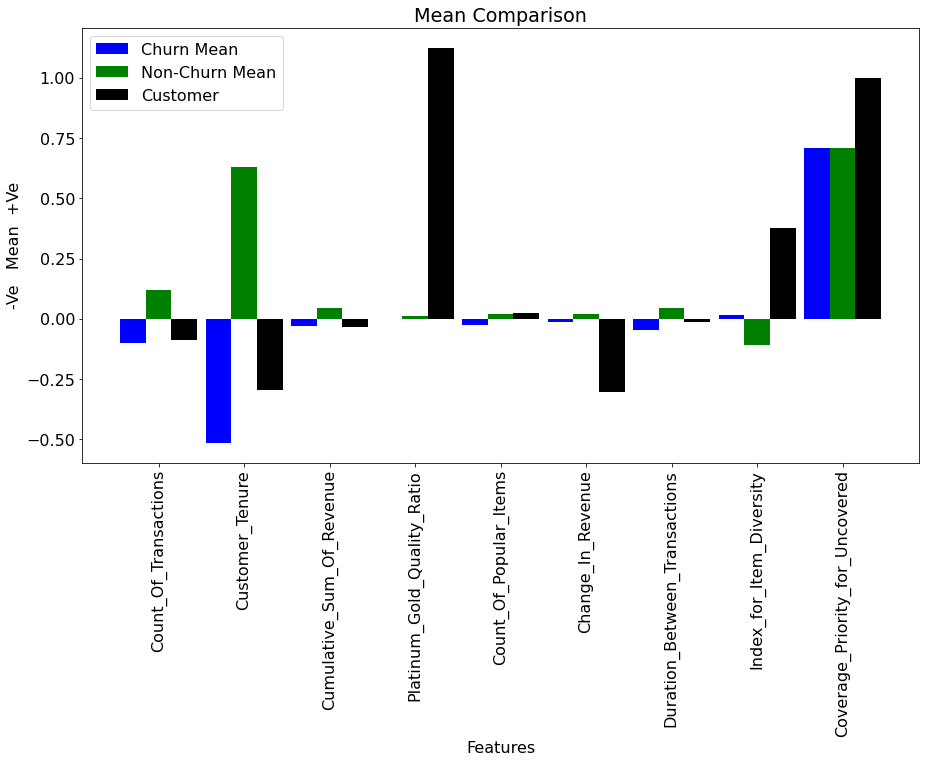

Customer Number: 0262041 |   Churn Status : [0.]

                                      Mean  Customer features
Count_Of_Transactions            11.495630               8.00
Customer_Tenure                 796.675040             581.00
Cumulative_Sum_Of_Revenue      8747.856565            3644.95
Platinum_Gold_Quality_Ratio    2202.643798            5000.00
Count_Of_Popular_Items            6.190183               8.00
Change_In_Revenue                 2.810854            -986.94
Duration_Between_Transactions    33.078464              30.00
Index_for_Item_Diversity          2.089135               2.75


In [91]:
plt.figure(figsize=(15,8))
xpos = np.arange(len(churn_mean))
plt.xticks(xpos, churn_mean.index)
plt.bar(xpos-0.3, churn_mean, label='Churn Mean',width=0.3, color='Blue')
plt.bar(xpos, non_churn_mean, label='Non-Churn Mean',width=0.3, color='Green')
plt.bar(xpos+0.3, customer_features.values.squeeze(), label='Customer',width=0.3, color='Black')
plt.legend()
plt.title('Mean Comparison')
plt.xlabel('Features')
plt.ylabel('-Ve   Mean  +Ve')
plt.xticks(rotation='vertical')
plt.show()

print('Customer Number: '+str(cust_id)+' |   Churn Status : '+str(churn_status))
print()
print(comparison_frame)

## Model Results for Output File

In [93]:
X_train_sub = X_train_sub.reset_index(drop=True)
res['customer_no'] = X_train_sub['customer_no']
yhat = logit.predict_proba(X_train_c)
probs_train = yhat[:, 1]
res['churn_probability_logit'] = probs_train

###  val data predictions/probability

cov_contribution = abs(X_val_c.values*logit_coef)
cov_contribution = pd.DataFrame(cov_contribution, columns = X_val_c.columns)
cov_contribution.drop(['Change_In_Revenue','Platinum_Gold_Quality_Ratio'], axis=1, inplace=True)
res_val =cov_contribution.div(cov_contribution.sum(axis=1), axis=0)
res_val = res_val.mul(100)

X_val_sub = X_val_sub.reset_index(drop=True)
res_val['customer_no'] = X_val_sub['customer_no']
yhat = logit.predict_proba(X_val_c)
probs_val = yhat[:, 1]
res_val['churn_probability_logit'] = probs_val


###  test data predictions/probability

cov_contribution = abs(X_test_c.values*logit_coef)
cov_contribution = pd.DataFrame(cov_contribution, columns = X_test_c.columns)
cov_contribution.drop(['Change_In_Revenue','Platinum_Gold_Quality_Ratio'], axis=1, inplace=True)
res_test =cov_contribution.div(cov_contribution.sum(axis=1), axis=0)
res_test = res_test.mul(100)

X_test_sub = X_val_sub.reset_index(drop=True)
res_test['customer_no'] = X_test_sub['customer_no']
yhat = logit.predict_proba(X_test_c)
probs_test = yhat[:, 1]
res_test['churn_probability_logit'] = probs_test

model_results = pd.concat([res,res_val,res_test])
model_results =pd.merge(model_results, xg_results, on=('customer_no'), how='left')
model_results =pd.merge(model_results, output_data, on=('customer_no'), how='left')

In [98]:
model_results

,Count_Of_Transactions,Customer_Tenure,Cumulative_Sum_Of_Revenue,Count_Of_Popular_Items,Duration_Between_Transactions,Index_for_Item_Diversity,Coverage_Priority_for_Uncovered,customer_no,churn_probability_logit,churn_probability_XGBoost,churn_standard,date_churned,Tier__c,cumulative_sum_revenue,ZI_Industry__c,Perc_DGOP,product_lines,Customer_specific_pop.Item,top_product_dims,top_department_dims
0,3.231796,72.349966,0.844178,0.032083,0.029756,15.442407,8.069814,3027184,0.262299,0.121378,0.0,2023-05-03 00:00:00.000000000,TIER4-Explorer,5473.40,Transportation,NaN,Books | Packaging | Software,DGIS49CFR,DGIS Software Products,Software
1,10.743833,75.947203,4.209839,1.409389,1.458046,6.231689,0.000000,0306131,0.704720,0.947224,1.0,2019-12-11 16:00:00.000028800,TIER1-Commander,558.06,Retail,66.666667,Facility Management | Labels,H-70976,Signs,Facility Management
2,4.794919,85.629960,1.030345,1.148891,1.368876,2.315995,3.711014,0415441,0.042083,0.006063,0.0,2023-01-20 16:19:12.000000000,TIER6,17438.64,Transportation,60.000000,Books | Labels | Placards,Z-EZ19,Worded Placards,Placards
3,5.423164,85.099617,1.752531,0.561576,0.376233,0.375680,6.411198,1626010,0.888530,0.996260,1.0,2017-10-17 00:00:00.000000000,TIER8,191.37,Construction,NaN,Imprinted Placards | Spacemaster,81-SP2212,Accessories,Imprinted Placards
4,13.286515,36.625072,6.637054,2.377242,9.577619,4.356878,27.139621,3029044,0.589766,0.860931,1.0,2020-12-15 00:00:00.000000000,TIER8,1092.94,Manufacturing,100.000000,Facility Management | Labels | Personal Compli...,H-22193,Personalized Waste Lables,Personal Compliance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33181,1.236335,88.919981,1.259559,0.369573,1.436171,1.236618,5.541763,3009689,0.088471,0.103324,1.0,2022-01-06 00:00:00.000000000,TIER8,3558.41,Chemical,NaN,Books | Placards,ERG0023,International Air Transport Association,Books
33182,3.204905,79.205647,0.273058,0.573426,9.812874,0.383608,6.546481,0414991,0.164131,0.387156,0.0,2023-05-06 00:00:00.000000000,TIER4-Explorer,976.48,Pharma & Healthcare,NaN,Labels | Personal Compliance,L335RP-00000030,Personalized DOT Labels and Markings,Personal Compliance
33183,5.448149,78.484274,1.649631,0.480082,1.584645,5.154361,7.198857,7009043,0.830261,0.995598,1.0,2019-05-04 00:00:00.000000000,TIER8,125.82,Transportation,NaN,Labels | Personal Compliance,L20R,Air Labels,Labels
33184,12.321214,75.907479,3.999275,1.275879,0.854786,5.641367,0.000000,0399708,0.715085,0.003487,0.0,2030-05-02 00:00:00.000000000,TIER8,127.88,Business Services,NaN,Labels,HML5,DOT Labels,Labels


## Output


In [96]:
def predict_churn(model, customerID):
    model_results_func = model_results[model_results['customer_no'] == customerID]
    if model == 'xgb':
        print("Customer No:", model_results_func['customer_no'].item())
        print("Churn Probability:", model_results_func['churn_probability_XGBoost'].item())
        print("Churned:", model_results_func['churn_standard'].item())
        print("Date Churned:", model_results_func['date_churned'].item())
        print("Spend:", model_results_func['Cumulative_Sum_Of_Revenue'].item())
        print("Tier:", model_results_func['Tier__c'].item())
        print("Customer Industry:", model_results_func['ZI_Industry__c'].item())
        print("Product Lines:", model_results_func['product_lines'].item())
        print("Top Item:", model_results_func['Customer_specific_pop.Item'].item())
        print("Top Product Dim:", model_results_func['top_product_dims'].item())
        print("Top Department Dim:", model_results_func['top_department_dims'].item())
    if model == 'logit':
        print("Customer No:", model_results_func['customer_no'].item())
        print("Churn Probability:", model_results_func['churn_probability_logit'].item())
        print("Churned:", model_results_func['churn_standard'].item())
        print("Date Churned:", model_results_func['date_churned'].item())
        print("Spend:", model_results_func['Cumulative_Sum_Of_Revenue'].item())
        print("Tier:", model_results_func['Tier__c'].item())
        print("Customer Industry:", model_results_func['ZI_Industry__c'].item())
        print("Product Lines:", model_results_func['product_lines'].item())
        print("Top Item:", model_results_func['Customer_specific_pop.Item'].item())
        print("Top Product Dim:", model_results_func['top_product_dims'].item())
        print("Top Department Dim:", model_results_func['top_department_dims'].item())
        importance = model_results_func[['Count_Of_Transactions',
                                        'Customer_Tenure',
                                       'Cumulative_Sum_Of_Revenue',
                                       'Count_Of_Popular_Items',
                                       'Duration_Between_Transactions',
                                       'Index_for_Item_Diversity',
                                       'Coverage_Priority_for_Uncovered',
                                       'Perc_DGOP']]
        ordered = importance.columns[importance.loc[importance.last_valid_index()].argsort()[::-1]]
        return importance[ordered]

In [97]:
predict_churn('xgb','0000520')

Customer No: 0000520
Churn Probability: 0.016434842720627785
Churned: 0.0
Date Churned: 2022-12-05 17:35:59.999971200
Spend: 1.269677476476817
Tier: TIER2-TrailBlazer
Customer Industry: Energy, Utilities & Waste
Product Lines: Books | Facility Management | Imprinted Placards | Labels | Personal Compliance | Placards | Spacemaster
Top Item: CFWM8
Top Product Dim: Personalized Waste Lables
Top Department Dim: Personal Compliance


In [ ]:
predict_churn('logit','0000520')